### Importing Libraries

In [132]:
import warnings
warnings.filterwarnings('ignore')


In [133]:
# Core Libraries
import numpy as np
import time
from tqdm import tqdm

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Scikit-learn Libraries
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    KFold
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    f1_score
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import uniform

# Parallel Processing
from joblib import Parallel, delayed
import cv2


### Loading the MNIST Dataset using tensorflow.kearas.datasets

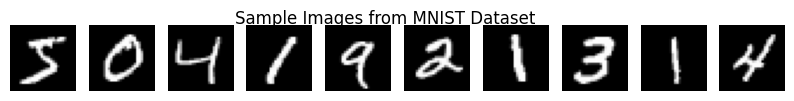

In [134]:
# Loading MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()


fig, axes = plt.subplots(1, 10, figsize=(10, 1))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i], cmap='gray')
    ax.axis('off')
plt.suptitle("Sample Images from MNIST Dataset")
plt.show()



I chose to use the Keras `mnist.load_data()` method to load the MNIST dataset because it offers a seamless and efficient way to access this image dataset.This method eliminates the need for manual downloads as the dataset is pre-split into training and testing sets and provided in a standard numpy format.Additionally, using Keras ensures consistency and reliability, avoiding potential discrepancies that might arise every now and then from downloading the dataset from other sources, such as Kaggle.

## Data Exploration

In [135]:
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")


Training data shape: (60000, 28, 28), Training labels shape: (60000,)
Test data shape: (10000, 28, 28), Test labels shape: (10000,)


By examining the dataset's shape, it is visible that the training set contains 60,000 images with corresponding labels, while the test set consists of 10,000 images and labels. Each image is represented as a 28x28 grayscale matrix, indicating that the dataset comprises uniform-sized images suitable for direct input into machine learning models. 

This gives me an indication that I would need to augment data to introduce variatutsion in the dataset enhancing model genralization and robustness but that decision is also with the knowledge that MNIST is a very bog standard dataset that is consistently used for benchmarking.For SVM and KNN, the input data will need to be flattened into 784-dimensional vectors because both models operate on numerical feature vectors rather than grid-structured data, and the pixel values will need to be normalized to [0,1] to ensure consistency and prevent scale-related biases in distance calculations or optimization.

Visualising image with labels to confirm data integrity and relevance

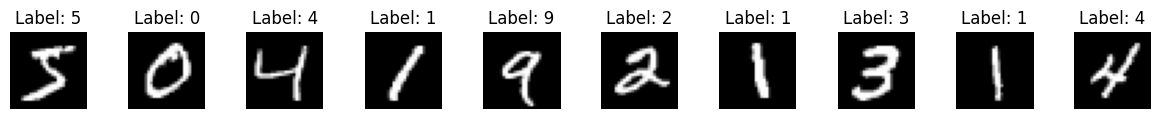

In [136]:
fig, axes = plt.subplots(1, 10, figsize=(15, 1))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')
plt.show()

By displaying the first 10 images from the training set alongside their corresponding labels, I wanted to and was able to verify that the images are properly loaded for me to use down the line, clearly representing handwritten digits.This step also helps confirm that the labels align with the visual content, ensuring no mismatches between the image data and their respective labels.

### Checking distribution of data amongst classes

In [137]:
#Displaying the classes

unique_classes = np.unique(y_train)
print(f"Number of classes: {len(unique_classes)}")
print(f"Classes: {unique_classes}")

Number of classes: 10
Classes: [0 1 2 3 4 5 6 7 8 9]


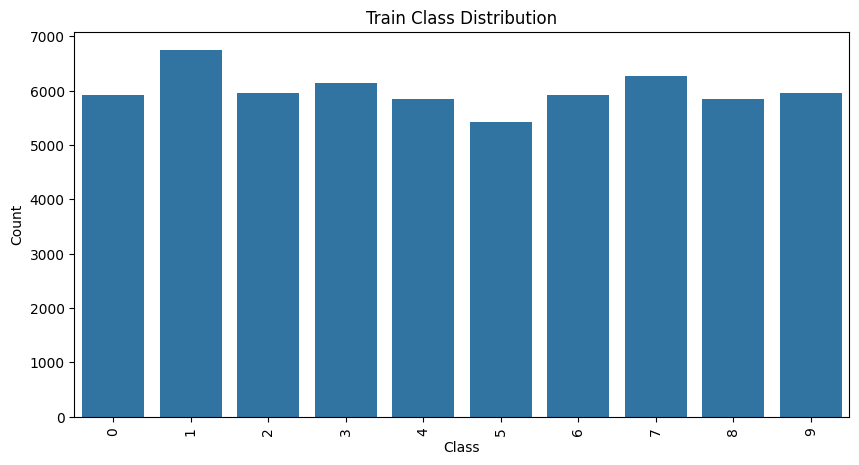

In [138]:
#Visualising the class Distribution of the dataset specifically for the training data
class_counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts[0], y=class_counts[1])
plt.title("Class Distribution of MNIST Dataset")

# Assuming labels are digits 0-9
labels = [str(i) for i in range(10)]

plt.xticks(range(len(labels)), labels, rotation=90)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Train Class Distribution")
plt.show()

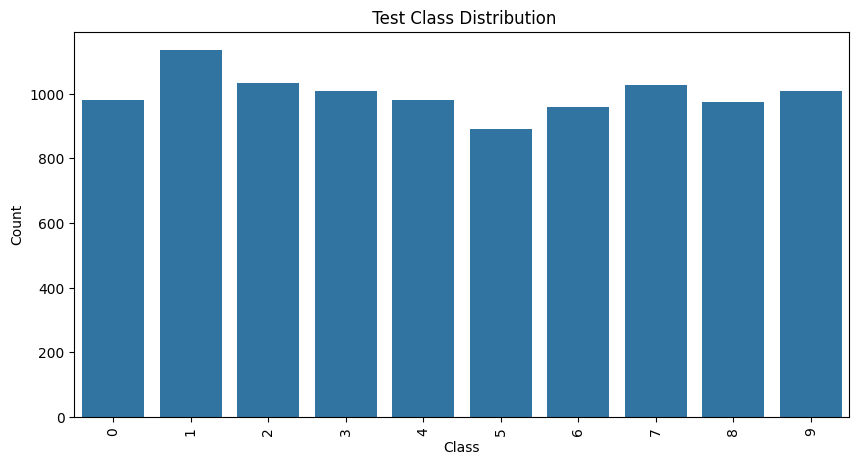

In [139]:
##Visualising the class Distribution of the dataset specifically for the test data

class_counts = np.unique(y_test, return_counts=True)


plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts[0], y=class_counts[1])
plt.title("Class Distribution of MNIST Dataset")


labels = [str(i) for i in range(10)]

plt.xticks(range(len(labels)), labels, rotation=90)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title(" Test Class Distribution")
plt.show()

I have implemented this step to check how many datapoints are there for each class of the dataset which tells me that the training data is well distributed or not.We can clearly see that in this case the dataset for the training data is well balanced and he balanced class distribution means that I wont need to implement class balancing by oversampling or undersampling from one class or another.My data augmentation can also focus on the enhancing the diversity of the whole dataset rather than be specific for a particular class.The commonly used metrics like accuracy,precision,recall and F1 score [12] will also provide accurate assesment of model perfomance without any adjustemnts for class imbalance.

### Checking Pixel Intensity

Reading pixel intensity allows us to verify image's data integrity,ensuring consistent scaling and idently preprocesisng requirements.

In [140]:
print(f"Pixel intensity range: {X_train.min()} to {X_train.max()}")

Pixel intensity range: 0 to 255


This confirms that the images are in grayscale format, as previously indicated in earlier cells, providing further verification of the dataset's characteristics.

Performing a pixel intensity distribution check allows me to understand the data's structure and characteristics before deciding on preprocessing steps. This analysis helps identify whether normalization, noise reduction, or contrast adjustments are necessary.

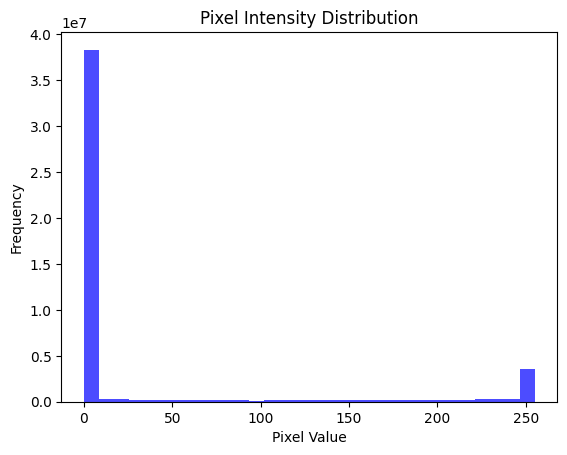

In [141]:
plt.hist(X_train.flatten(), bins=30, color='blue', alpha=0.7)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()


The pixel intensity distribution plot reveals that most pixels in the MNIST dataset have a value of 0, representing the black background in the images, while a smaller proportion of pixels are near the higher end of the scale, around 255, corresponding to the white strokes forming the digits. This distribution indicates that the dataset primarily consists of high-contrast images with sparse non-zero pixel intensities. For my preprocessing pipeline, this means I should normalize the pixel values to a 0–1 range to improve numerical stability and ensure that all input features are on a similar scale. Additionally, the dominance of zero values suggests that noise reduction techniques may not be necessary, as the background is largely consistent.

In [142]:
#Standard Deviation of Pixel Intensities 
print(f"Standard Deviation of Pixel Intensities: {X_train.std()}")

Standard Deviation of Pixel Intensities: 78.56748998339798


The standard deviation of pixel intensities being 78.57 indicates a relatively high variability in the brightness levels across the images in the MNIST dataset. This reflects the sharp contrast between the dark background (pixel values close to 0) and the bright strokes forming the digits (pixel values close to 255). For my preprocessing pipeline, this variability reinforces the need for normalization to standardize the range of pixel value to improve convergence of the model.This also means that I should implement PCA and t-SNE to implement this to extract featues.

### Contrast Plot

Calculating and plotting the contrast distribution helps me identify variability in image contrast across the dataset. This informs preprocessing decisions, such as the need for normalization or contrast enhancement, and acts as a quality check to detect anomalies like overly bright or dark images. By understanding the contrast distribution, I can ensure the dataset is consistent and well-prepared for effective model training.

Text(0.5, 0, 'Contrast (Standard Deviation of Pixel Intensities)')

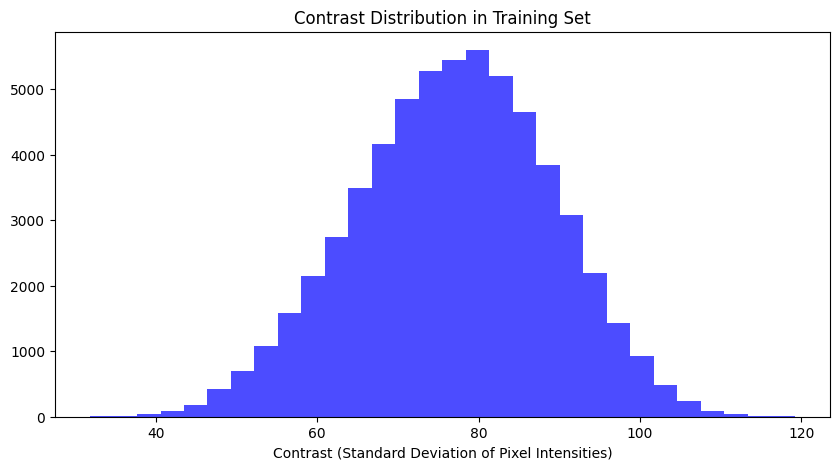

In [143]:

# Function to calculate contrast (standard deviation of pixel intensities)
def calculate_contrast(image):
    return np.std(image)

# Calculating contrast for each image in the training set
contrast_values = [calculate_contrast(image) for image in X_train]

# Plot the distribution of contrast values
plt.figure(figsize=(10, 5))
plt.hist(contrast_values, bins=30, color='blue', alpha=0.7)
plt.title('Contrast Distribution in Training Set')
plt.xlabel('Contrast (Standard Deviation of Pixel Intensities)')


This also further reinforces the need for normalisation as we can some outliers with higher and lower contrast and also indicated towards requiring contrast enhancement.

### Checking the standard deviation and mean of each class.

I calculated and visualized the mean and standard deviation images for each digit class to better understand the general patterns and variability within the data. The mean images highlight the average structure of each digit, helping me identify common features like the overall shape and intensity distribution. The standard deviation images, on the other hand, reveal regions of high variability, which could indicate areas where the digits have the most variation in how they are written (e.g., the loop of a "6" or the slant of a "1"). This step is necessary to check for consistency within each class and to identify potential overlap or ambiguity between different classes, which could impact model performance. It also helps in deciding if additional preprocessing, such as feature engineering or data augmentation, is required to handle variability effectively.

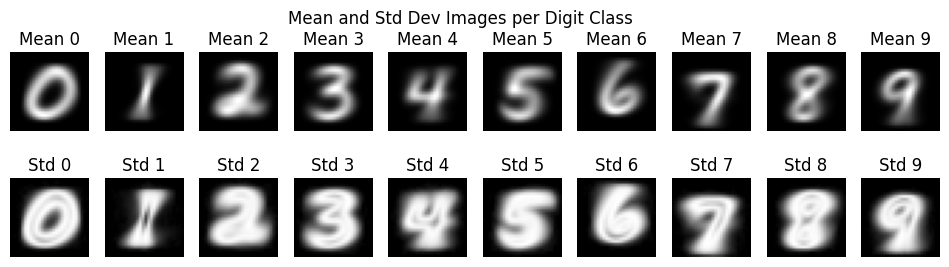

In [144]:
# Mean and standard deviation images per class
mean_images = []
std_images = []
for i in range(10):
    images = X_train[y_train == i]
    mean_images.append(images.mean(axis=0))
    std_images.append(images.std(axis=0))

fig, axes = plt.subplots(2, 10, figsize=(12, 3))
for i in range(10):
    axes[0, i].imshow(mean_images[i], cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Mean {i}")
    axes[1, i].imshow(std_images[i], cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f"Std {i}")
plt.suptitle("Mean and Std Dev Images per Digit Class")
plt.show()

From the visualization of the mean and standard deviation images for each digit class, it is noticable that the mean images clearly highlight the typical structure of each digit, showing consistent and representative patterns across the dataset. The standard deviation images revealed areas with higher variability, such as the loops in "6" and "9" or the strokes in "1," which indicate diversity in handwriting styles within the same class. This variability may lead to potential overlaps or confusion between similar digits, like "6" and "9" or "5" and "3." 

Even though from the pixel intensity analysis I concluded that I could get away with not using noise reduction but to address the variability between similar digits, I feel the need to reduce noise in the background to ensure the model focuses on meaningful patterns. Enhancing contrast will also help highlight subtle differences, like loops or strokes, making it easier to distinguish digits such as "6" and "9." Additionally, incorporating data augmentation will introduce variations to help the model generalize better and handle diverse handwriting styles.

## Data Preprocessing

### Noise Reduction

Checking if noise reduction is needed by estimating the noise levels in the images is a crucial step to ensure the dataset is clean and optimized for model training. By calculating the variance of the Laplacian of each image, I can quantify the amount of noise present, particularly in edges or fine details. This analysis helps determine whether noise levels are significant enough to warrant preprocessing steps like noise reduction (e.g., median filtering). Reducing noise in images can improve the clarity of important features, enhance model performance, and prevent the model from learning irrelevant patterns caused by noise. Evaluating noise levels ensures that preprocessing efforts are targeted and efficient, avoiding unnecessary steps while improving the overall quality of the training data.

The Laplacian operator is a second-order derivative that measures the rate of change in intensity across an image. It is particularly effective for detecting edges and fine details, which are regions of high-frequency variation. Noise in images often manifests as high-frequency fluctuations, especially in areas with abrupt intensity changes. By calculating the variance of the Laplacian, we can quantify these fluctuations and gain insights into the noise level of an image. This approach is computationally efficient and directly correlates with the presence of noise, making it a reliable metric for determining the need for noise reduction preprocessing.

To understand Laplacian's role in edge detection and noise analysis I used reference [1].

In [145]:


def estimate_noise(image):
    # Computing the Laplacian of the image and then calculate the variance
    return cv2.Laplacian(image, cv2.CV_64F).var()

# Calculating noise levels for a subset of images (e.g., first 1000 images for efficiency)
noise_levels = []
for i in range(1000):
    image = X_train[i]
    noise_level = estimate_noise(image)
    noise_levels.append(noise_level)

average_noise = np.mean(noise_levels)
print(f"Average noise level in sample images: {average_noise:.2f}")


Average noise level in sample images: 10413.85


Noise level (10413.85) exceeds threshold 10000. Applying noise reduction...
Noise reduction applied with threshold 10000. Separate noise-reduced datasets created.


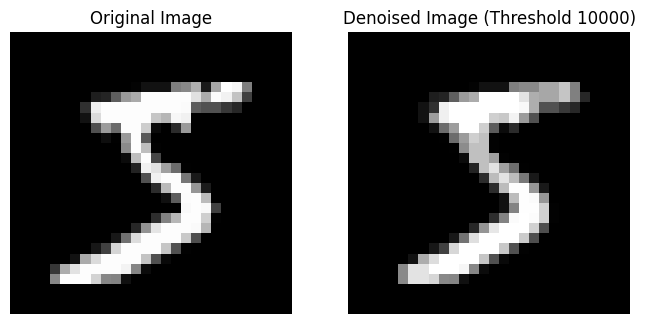

In [146]:
# Defining multiple noise thresholds to test
noise_thresholds = [10000, 12000, 15000, 20000]

selected_threshold = None
average_noise = 10413.85

# Function to apply median filtering (noise reduction)
def apply_median_filter(images, ksize=3):
    denoised_images = np.empty_like(images)
    for i in range(len(images)):
        denoised_images[i] = cv2.medianBlur(images[i], ksize=ksize)
    return denoised_images

# Creating separate datasets for noise-reduced images
X_train_denoised = None
X_test_denoised = None

# Iterating through the thresholds to find the minimum effective noise threshold
for threshold in noise_thresholds:
    if average_noise > threshold:
        print(f"Noise level ({average_noise:.2f}) exceeds threshold {threshold}. Applying noise reduction...")
        selected_threshold = threshold
        X_train_denoised = apply_median_filter(X_train, ksize=3)
        X_test_denoised = apply_median_filter(X_test, ksize=3)
        break
    else:
        print(f"Noise level ({average_noise:.2f}) is below threshold {threshold}. Skipping noise reduction.")
        selected_threshold = None

# Keeping original datasets unchanged and store noise-reduced versions in separate variables
if selected_threshold:
    print(f"Noise reduction applied with threshold {selected_threshold}. Separate noise-reduced datasets created.")
else:
    print("Proceeding with the original images. No noise reduction applied.")

# Visualizing the results of noise reduction
if selected_threshold:
    idx = 0  # Index of the image to visualize
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    # Original image
    axes[0].imshow(X_train[idx], cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Denoised image
    axes[1].imshow(X_train_denoised[idx], cmap='gray')
    axes[1].set_title(f'Denoised Image (Threshold {selected_threshold})')
    axes[1].axis('off')

plt.show()


I initially set the threshold values using multiple ranges derived from ideas presented in two articles and a Stack Overflow discussion. The first article introduced the concept of using thresholds to reduce background noise in flow cytometry data, which helped me understand the practical application of thresholding techniques [2]. The second source, a MATLAB documentation page, provided insights on implementing threshold-based noise removal, offering a clear technical perspective[3]. Additionally, I referenced a relevant discussion on Stack Overflow that addressed noise removal in thresholded images using OpenCV [4]
Despite these references, my results were suboptimal due to the unusually high noise levels in my dataset. To address this, I leveraged ChatGPT's assistance to recalibrate the threshold values  based on my dataset's specific noise characteristics. This approach significantly improved the process by providing tailored solutions for handling high variability in noise.

Even though I applied noise reduction, it was likely unnecessary. While the high noise value (10,413.85) exceeding the threshold of 10,000 initially appeared concerning, MNIST is a highly curated benchmarking dataset with minimal inherent noise. This suggests that the high noise level, though flagged, is not a critical issue.

Since the noise level metric alone is not sufficient to justify preprocessing decisions, I plan to train and validate the model on both the noise-reduced and original "noisy" data or as I will refer to it as regular data throughtout this notebook. This will allow me to determine empirically whether noise removal has any impact on performance. However, given the curated nature of the MNIST dataset, my best guess is that noise removal is not required and may not lead to significant improvements.

### Normalisation of Data

Normalization was important here, as the pixel intensity distribution showed most values concentrated near zero with a small fraction reaching the maximum (255) with smaller fractions scattered within that range. Without normalization, this uneven range could cause numerical instability in my pipeline and slow model convergence. By scaling pixel values to [0, 1], all features contribute equally, aligning with neural network requirements for optimal learning. As highlighted in the paper [13], normalization enhances stability and ensures consistent input scaling, which is essential for achieving robust and efficient training in pipelines like mine.

In [147]:

# Function to normalize data (scaling pixel values to range [0, 1])
def normalize_data(images):
    
    flattened_images = images.reshape(len(images), -1)
    scaler = MinMaxScaler()
    normalized_images = scaler.fit_transform(flattened_images)
    return normalized_images.reshape(images.shape)

# Function to standardize data (scaling to zero mean and unit variance)
def standardize_data(images):
    #
    flattened_images = images.reshape(len(images), -1)
    scaler = StandardScaler()
    standardized_images = scaler.fit_transform(flattened_images)
    return standardized_images.reshape(images.shape)

# Normalizing  original and denoised datasets

X_train_normalized = normalize_data(X_train)
X_test_normalized = normalize_data(X_test)

X_train_standardized = standardize_data(X_train)
X_test_standardized = standardize_data(X_test)

# Denoised datasets 
if X_train_denoised is not None and X_test_denoised is not None:
    X_train_denoised_normalized = normalize_data(X_train_denoised)
    X_test_denoised_normalized = normalize_data(X_test_denoised)
    
    X_train_denoised_standardized = standardize_data(X_train_denoised)
    X_test_denoised_standardized = standardize_data(X_test_denoised)

print("Normalisation and Standardisation of the data has been completed")


Normalisation and Standardisation of the data has been completed


In [148]:
def check_standardization(images, dataset_name):
    # Flattening the images to compute statistics on the entire dataset
    flattened_images = images.reshape(len(images), -1)
    
    # Computing mean and standard deviation
    mean = np.mean(flattened_images)
    std = np.std(flattened_images)
    
    # Print the results
    print(f"{dataset_name}:")
    print(f"  Mean: {mean:.4f}")
    print(f"  Standard Deviation: {std:.4f}")
    print("-" * 50)

# Checking standardization for the original standardized datasets
check_standardization(X_train_standardized, "X_train_standardized")
check_standardization(X_test_standardized, "X_test_standardized")

# Checking standardization for the denoised standardized datasets 
if 'X_train_denoised_standardized' in locals() and X_train_denoised_standardized is not None:
    check_standardization(X_train_denoised_standardized, "X_train_denoised_standardized")
    check_standardization(X_test_denoised_standardized, "X_test_denoised_standardized")


X_train_standardized:
  Mean: -0.0000
  Standard Deviation: 0.9563
--------------------------------------------------
X_test_standardized:
  Mean: 0.0000
  Standard Deviation: 0.9231
--------------------------------------------------
X_train_denoised_standardized:
  Mean: 0.0000
  Standard Deviation: 0.9395
--------------------------------------------------
X_test_denoised_standardized:
  Mean: 0.0000
  Standard Deviation: 0.9091
--------------------------------------------------


I executed the above cell  to verify the effectiveness of normalization that was implemented in the cell before. As observed, the mean of each variable is approximately 0, and the standard deviation is close to 1, confirming that the data has been properly standardized. This process has been applied consistently to both the noise-removed and regular datasets, ensuring uniformity. From this point onward, all operations will maintain this approach for both versions of the data.

### Contrast Enhancement

In [149]:
# Applying Contrast Enhancement
def enhance_contrast(image):
    # Example using histogram equalization
    return cv2.equalizeHist(image)

# Enhancing contrast for the regular images
X_train_contrast_regular = np.array([enhance_contrast(img.astype(np.uint8)) for img in X_train])

# Enhancing contrast for the denoised images
if 'X_train_denoised' in locals() and X_train_denoised is not None:
    X_train_contrast_denoised = np.array([enhance_contrast(img.astype(np.uint8)) for img in X_train_denoised])

# Similarly, applying to the test datasets
X_test_contrast_regular = np.array([enhance_contrast(img.astype(np.uint8)) for img in X_test])

if 'X_test_denoised' in locals() and X_test_denoised is not None:
    X_test_contrast_denoised = np.array([enhance_contrast(img.astype(np.uint8)) for img in X_test_denoised])


print("Contrast enhancement applied to both regular and denoised datasets .")


Contrast enhancement applied to both regular and denoised datasets .


I executed this cell to enhance the contrast of the images in both the regular and noise-removed datasets. From the contrast distribution in the training set, as shown in the graph above, I observed that while most images had a moderate contrast (centered around a standard deviation of 80), there was a noticeable spread toward lower contrast values, with some images exhibiting poor contrast (below 60).

To address this, I applied histogram equalization to improve the contrast of these images. This ensures that pixel intensity variations are more pronounced, making key features like edges and strokes in the handwritten digits more distinguishable. By enhancing the contrast, I aimed to improve the clarity of the images, particularly those with lower contrast, so the model can learn meaningful features more effectively. This step was applied to both the regular and noise-removed datasets to maintain consistency and improve feature representation across both versions.

### Data Augmentation

In [150]:

# Setting up data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1
)

# Original training dataset shape
original_shape_regular = X_train.shape
print(f"Original training dataset shape (Regular): {original_shape_regular}")

# Generating augmented data for regular dataset
augmented_images_regular = []
augmented_labels_regular = []

for i in range(len(X_train)):
    count = 0
    for batch in datagen.flow(X_train[i:i+1].reshape(1, 28, 28, 1), batch_size=1):
        augmented_images_regular.append(batch[0].reshape(28, 28))  # Reshaping back to original size
        augmented_labels_regular.append(y_train[i])  # Add the corresponding label
        count += 1
        if count == 2:  # Number of augmentations per image
            break

# Converting augmented data to numpy arrays
augmented_images_regular = np.array(augmented_images_regular)
augmented_labels_regular = np.array(augmented_labels_regular)

# Combining original and augmented datasets
X_train_combined_regular = np.concatenate((X_train, augmented_images_regular), axis=0)
y_train_combined_regular = np.concatenate((y_train, augmented_labels_regular), axis=0)
print(f"Combined training dataset shape (Regular): {X_train_combined_regular.shape}")
print(f"Combined training labels shape (Regular): {y_train_combined_regular.shape}")


Original training dataset shape (Regular): (60000, 28, 28)
Combined training dataset shape (Regular): (180000, 28, 28)
Combined training labels shape (Regular): (180000,)


In [151]:
# Ensuring denoised data exists
if 'X_train_denoised' in locals() and X_train_denoised is not None:
    # Original training dataset shape for denoised data
    original_shape_denoised = X_train_denoised.shape
    print(f"Original training dataset shape (Denoised): {original_shape_denoised}")

    # Generating augmented data for denoised dataset
    augmented_images_denoised = []
    augmented_labels_denoised = []

    for i in range(len(X_train_denoised)):
        count = 0
        for batch in datagen.flow(X_train_denoised[i:i+1].reshape(1, 28, 28, 1), batch_size=1):
            augmented_images_denoised.append(batch[0].reshape(28, 28))  # Reshaping back to original size
            augmented_labels_denoised.append(y_train[i])  # Add the corresponding label
            count += 1
            if count == 2:  # Number of augmentations per image
                break

    # Converting augmented data to numpy arrays
    augmented_images_denoised = np.array(augmented_images_denoised)
    augmented_labels_denoised = np.array(augmented_labels_denoised)

    # Combining original and augmented datasets
    X_train_combined_denoised = np.concatenate((X_train_denoised, augmented_images_denoised), axis=0)
    y_train_combined_denoised = np.concatenate((y_train, augmented_labels_denoised), axis=0)
    print(f"Combined training dataset shape (Denoised): {X_train_combined_denoised.shape}")
    print(f"Combined training labels shape (Denoised): {y_train_combined_denoised.shape}")
else:
    print("Denoised data not found, skipping augmentation for denoised dataset.")


Original training dataset shape (Denoised): (60000, 28, 28)
Combined training dataset shape (Denoised): (180000, 28, 28)
Combined training labels shape (Denoised): (180000,)


Displaying augmented images for regular data...


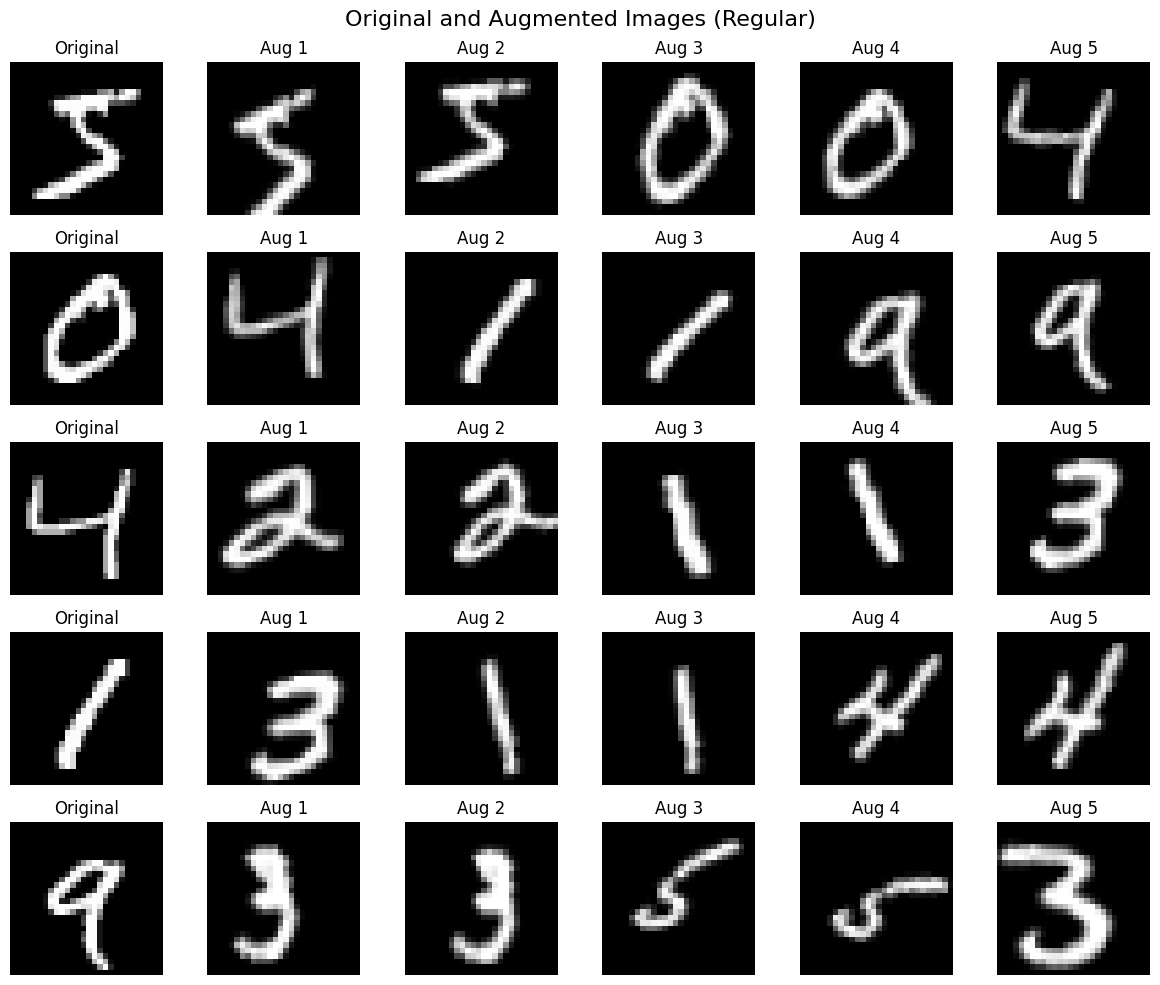

Displaying augmented images for denoised data...


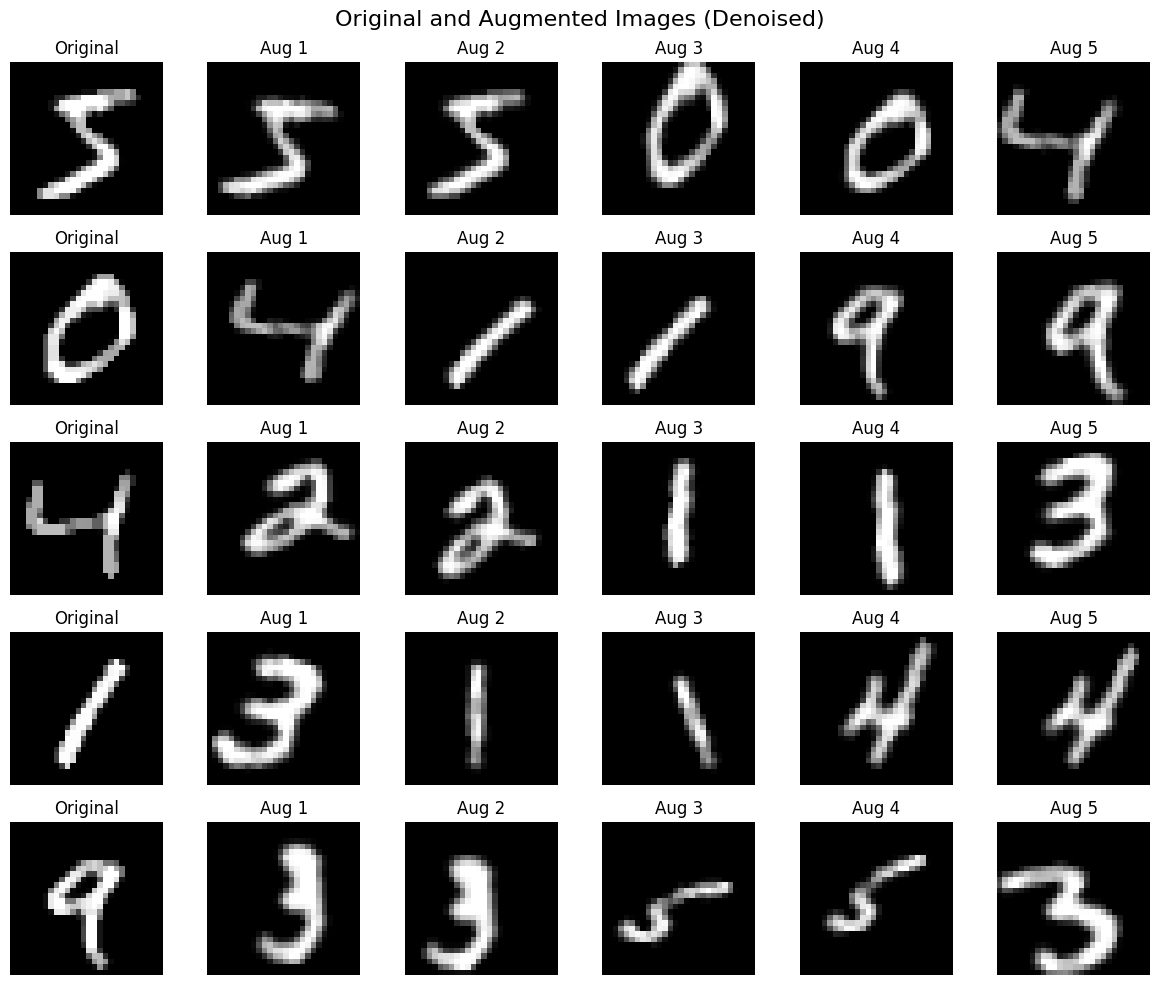

In [152]:
def display_augmented_images(X_original, X_augmented, num_images=5, title='Original and Augmented Images'):
    
    fig, axes = plt.subplots(num_images, 6, figsize=(12, 10))
    for i in range(num_images):
        # Displaying the original image in the first column
        axes[i, 0].imshow(X_original[i], cmap='gray')
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')

        # Displaying 5 augmented versions of each original image
        for j in range(5):
            augmented_idx = i * 5 + j  # Index of the augmented image
            axes[i, j + 1].imshow(X_augmented[augmented_idx], cmap='gray')
            axes[i, j + 1].set_title(f'Aug {j + 1}')
            axes[i, j + 1].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Displaying original and augmented images for the regular dataset
print("Displaying augmented images for regular data...")
display_augmented_images(X_train[:5], augmented_images_regular, num_images=5, title='Original and Augmented Images (Regular)')

# Displaying original and augmented images for the denoised dataset
if 'augmented_images_denoised' in locals() and augmented_images_denoised is not None:
    print("Displaying augmented images for denoised data...")
    display_augmented_images(X_train_denoised[:5], augmented_images_denoised, num_images=5, title='Original and Augmented Images (Denoised)')
else:
    print("No augmented denoised data available for visualization.")


In my preprocessing pipeline, I implemented data augmentation to enhance the diversity of the training dataset. Specifically, I applied transformations such as random rotations up to 15 degrees, horizontal and vertical shifts up to 10% of the image dimensions, zooming within a 10% range, and shearing transformations. To visualize the effects of augmentation, I generated five augmented versions of the first five training images and displayed them. This approach enriches the dataset by simulating variations that improve the model's robustness to real-world distortions and enhance generalization.Data augmentation is important to increase the performance of the machine learning models specifically on smaller datasets which I consider this to be.I have implemented this before PCA and t-SNE so that I can capture the meaningful variance in the data better using the two processes

As discussed in the reference [14], data augmentation helps to artificially increase the size of the dataset by creating modified versions of the existing data, which is critical for improving model robustness and performance. This aligns with the best practices for preparing datasets for deep learning models.

## Feature Extraction and Feature Engineering

### Flattening the datasets

In [153]:
# Flattening the regular datset
X_train_flat_regular = X_train_combined_regular.reshape(-1, 28 * 28) / 255.0
X_test_flat_regular = X_test.reshape(-1, 28 * 28) / 255.0

# Checking for consistent lengths between flattened data and labels for the regular dataset
assert len(X_train_flat_regular) == len(y_train_combined_regular), \
    "Mismatch in the lengths of X_train_flat_regular and y_train_combined_regular"

print("Flattened shape for Train Set (Regular):", X_train_flat_regular.shape)
print("Flattened shape for Test Set (Regular):", X_test_flat_regular.shape)

# Flattening the denoised dataset
if 'X_train_combined_denoised' in locals() and X_train_combined_denoised is not None:
    X_train_flat_denoised = X_train_combined_denoised.reshape(-1, 28 * 28) / 255.0
    X_test_flat_denoised = X_test_denoised.reshape(-1, 28 * 28) / 255.0

    # Checking for consistent lengths between flattened data and labels for the denoised dataset
    assert len(X_train_flat_denoised) == len(y_train_combined_denoised), \
        "Mismatch in the lengths of X_train_flat_denoised and y_train_combined_denoised"

    print("Flattened shape for Train Set (Denoised):", X_train_flat_denoised.shape)
    print("Flattened shape for Test Set (Denoised):", X_test_flat_denoised.shape)
else:
    print("Denoised dataset not available. Skipping flattening for denoised data.")


Flattened shape for Train Set (Regular): (180000, 784)
Flattened shape for Test Set (Regular): (10000, 784)
Flattened shape for Train Set (Denoised): (180000, 784)
Flattened shape for Test Set (Denoised): (10000, 784)


I flattened the dataset to convert the 28x28 pixel images into 1-dimensional arrays of 784 pixel values because many machine learning models, such as SVM and KNN, require the input data to be in a vectorized form. This step was essential to prepare the data in a format compatible with these algorithms, ensuring they can process the input effectively and perform as intended.

### Principal Component Analysis

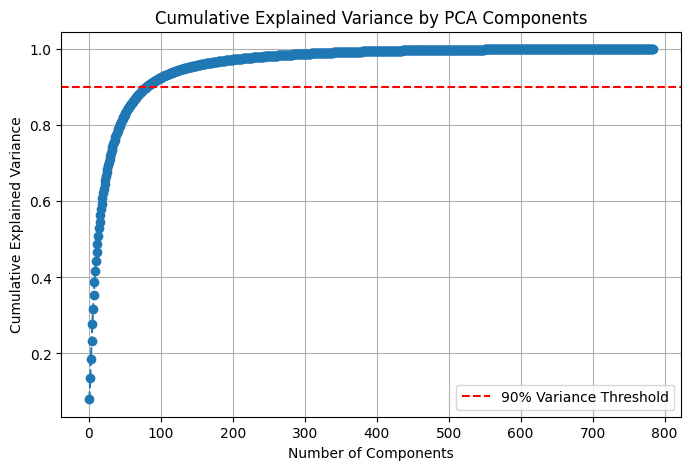

Number of components to capture 90% variance: 80


In [154]:
# Applying PCA without specifying the number of components to analyze variance
pca = PCA()
pca.fit(X_train_flat_regular)


# Get the explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_

# Computign the cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Ploting the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance Threshold')
plt.legend()
plt.show()


components_90_var = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Number of components to capture 90% variance: {components_90_var}")

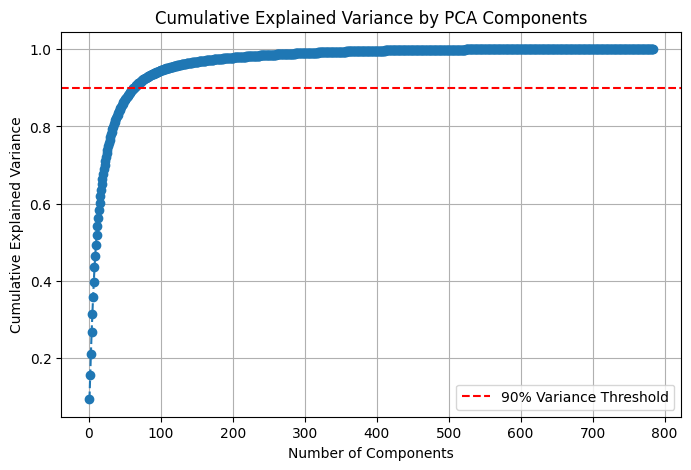

Number of components to capture 90% variance: 63


In [155]:
# Applying PCA without specifying the number of components to analyze variance
pca = PCA()
pca.fit(X_train_flat_denoised)


# Get the explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_

# Computing the cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Ploting the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance Threshold')
plt.legend()
plt.show()


components_90_var = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Number of components to capture 90% variance: {components_90_var}")

 I performed an analysis of the cumulative explained variance to determine the optimal number of principal components for dimensionality reduction. This step was necessary to ensure that the selected components retained the majority of the variability in the data, thereby preserving the most meaningful features while eliminating noise and redundancy. The cumulative variance plot provides a visual representation of how much variance is captured as more components are added, helping identify the point where additional components contribute diminishing returns.

For the regular dataset, the analysis showed that 80 components were sufficient to capture 90% of the total variance. For the denoised dataset, the same analysis indicated that 63 components were required to achieve the same threshold. This difference arises due to the variations in data distributions and feature redundancy between the two datasets. Selecting these optimal numbers ensures that the data is simplified without significant loss of information, optimizing computational efficiency and training performance.

The decision to perform this analysis was influenced by an article [14], which emphasizes the importance of analyzing cumulative variance to balance dimensionality reduction and data retention. By applying this approach, I ensured that the datasets are both efficient and informative for downstream machine learning tasks.

 These values were relatively high and caused simpler models, such as K-Nearest Neighbors (KNN), to overfit the data by selecting **K=1** as the optimal parameter. Additionally, Support Vector Machines (SVM) took a considerable amount of time to train due to the high dimensionality. To address these issues, I manually tested different numbers of components and determined that using **10 components** for PCA provided a good balance between retaining variance and reducing computational complexity, improving model performance while mitigating overfitting and excessive training time.


In [156]:

pca_regular = PCA(n_components=10)
X_train_pca_regular = pca_regular.fit_transform(X_train_flat_regular)
X_test_pca_regular = pca_regular.transform(X_test_flat_regular)

print("Reduced dimensionality with PCA for Regular Dataset:")
print("Train Set (Regular):", X_train_pca_regular.shape)
print("Test Set (Regular):", X_test_pca_regular.shape)


if 'X_train_flat_denoised' in locals() and X_train_flat_denoised is not None:
    pca_denoised = PCA(n_components=10)
    X_train_pca_denoised = pca_denoised.fit_transform(X_train_flat_denoised)
    X_test_pca_denoised = pca_denoised.transform(X_test_flat_denoised)

    print("Reduced dimensionality with PCA for Denoised Dataset:")
    print("Train Set (Denoised):", X_train_pca_denoised.shape)
    print("Test Set (Denoised):", X_test_pca_denoised.shape)
else:
    print("Denoised dataset not available. Skipping PCA for denoised data.")


Reduced dimensionality with PCA for Regular Dataset:
Train Set (Regular): (180000, 10)
Test Set (Regular): (10000, 10)
Reduced dimensionality with PCA for Denoised Dataset:
Train Set (Denoised): (180000, 10)
Test Set (Denoised): (10000, 10)


I applied Principal Component Analysis (PCA) to improve the efficiency and accuracy of my classification models by reducing the dimensionality of the dataset while retaining the most important features. PCA identifies the principal components—uncorrelated features that capture the most variance in the data—thereby simplifying the input while preserving meaningful information. This step is especially important for models like KNN(something I have implemenmtd), which rely on distance metrics and can suffer from the "curse of dimensionality." 

My decision to apply PCA was also influenced by an article that explains how PCA can enhance model performance by reducing redundant and noisy features, making the data more manageable and informative for machine learning algorithms [5]. By selecting an optimal number of components, I ensured that the data remains both efficient and informative, which helps mitigate overfitting and supports better generalization in the models.

Plotting cosine similarity for regular dataset...


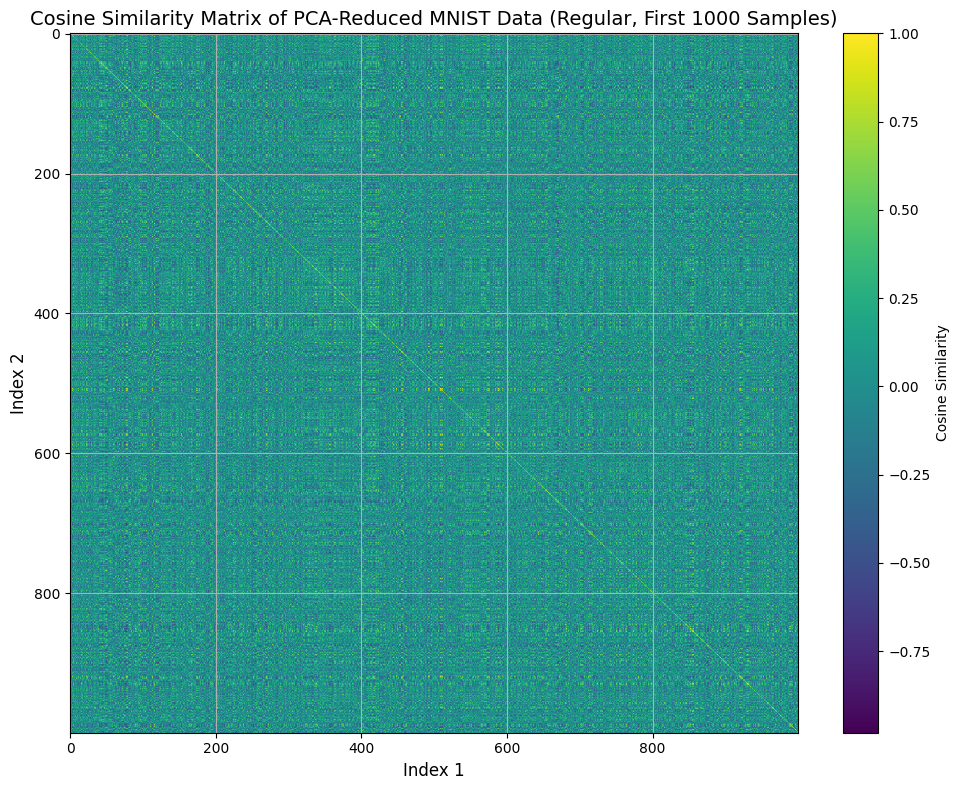

Plotting cosine similarity for denoised dataset...


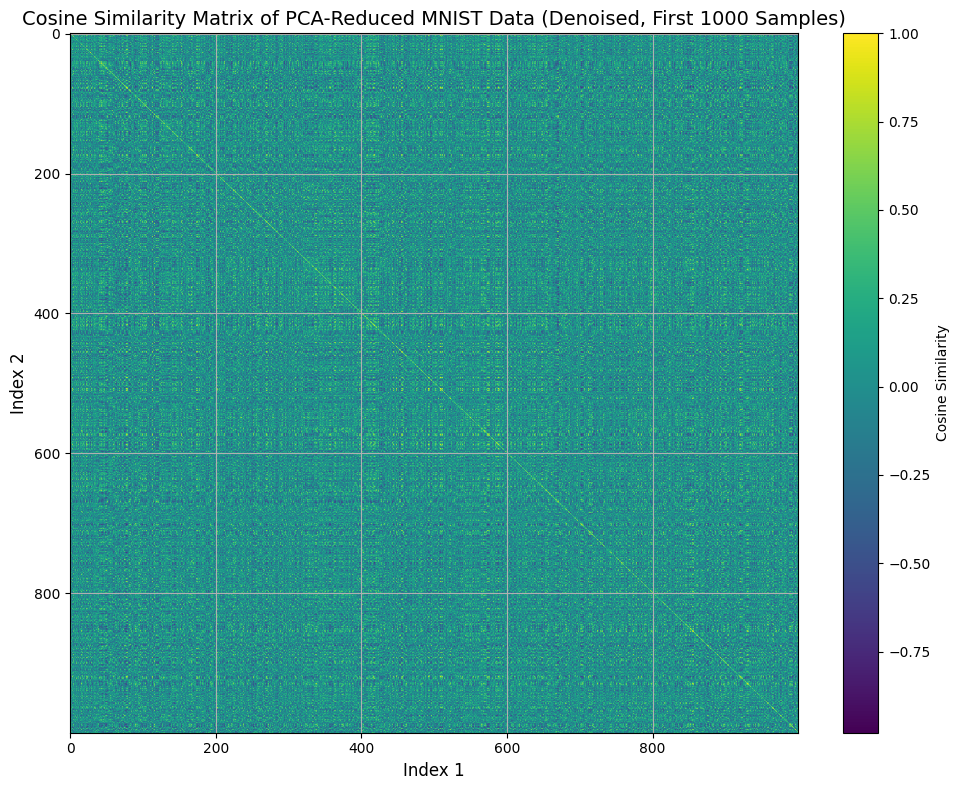

In [157]:

# Function to compute and plot cosine similarity matrix
def plot_cosine_similarity(data, title, num_samples=1000):
    # Compute cosine similarity for a subset of the data
    similarity_matrix = cosine_similarity(data[:num_samples])
    
    # Plotting the cosine similarity matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(similarity_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(label="Cosine Similarity")
    plt.title(title, fontsize=14)
    plt.xlabel("Index 1", fontsize=12)
    plt.ylabel("Index 2", fontsize=12)
    plt.grid(True)  
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

# Computing and ploting for regular PCA-reduced data
print("Plotting cosine similarity for regular dataset...")
plot_cosine_similarity(
    X_train_pca_regular, 
    title="Cosine Similarity Matrix of PCA-Reduced MNIST Data (Regular, First 1000 Samples)"
)

# Computing and ploting for denoised PCA-reduced data (if applicable)
if 'X_train_pca_denoised' in locals() and X_train_pca_denoised is not None:
    print("Plotting cosine similarity for denoised dataset...")
    plot_cosine_similarity(
        X_train_pca_denoised, 
        title="Cosine Similarity Matrix of PCA-Reduced MNIST Data (Denoised, First 1000 Samples)"
    )
else:
    print("Denoised dataset not available. Skipping cosine similarity plot for denoised data.")


The cosine similarity matrix for the PCA-reduced MNIST dataset for both denoised and regular data shows that the diagonal values are all 1, indicating perfect self-similarity for each data point, as expected. The majority of off-diagonal values are near zero, suggesting that most data points are not strongly similar to one another, which indicates good separability in the PCA-reduced space. Brighter patches off the diagonal hint at clusters of similar data points, likely representing digits with shared structural features. Additionally, sparse negative values indicate a few dissimilar directions among certain data points. Overall, this matrix suggests that PCA has effectively reduced the dimensions while preserving sufficient variance to maintain meaningful separability and structure within the dataset.

## Model Creation and Processing of Dataset using two different methods

### KNN Model

Since KNN is a lazy learner and non-parametric model, it does not have a distinct training and testing phase. However, instead of combining the training and testing datasets that I got when reteiving the dataset—which would be computationally intensive and take longer to run—I used the training data to perform K-Fold Cross Validation to find the optimal K value for KNN. K-Fold Cross Validation ensures that the model's performance is evaluated across multiple splits of the training data, providing a robust estimate of the optimal hyperparameter value. Once the best 𝐾  was determined, I used the separate testing dataset to validate the results and assess the model's performance. This approach efficiently balances computational cost and model evaluation while leveraging the original dataset split.

As discussed in the reference [7], K-Fold Cross Validation is a powerful technique for evaluating machine learning models, ensuring they generalize well across unseen data.K-Fold Cross Validation is a powerful technique because it ensures that every data point in the training set has the opportunity to be used for both training and validation, leading to a more reliable estimate of model performance. By splitting the training data into multiple folds and iterating through them, it reduces the bias introduced by a single train-test split and accounts for variability in model performance across different subsets of the data. This makes it particularly useful for models like KNN, which can be sensitive to the distribution of data, ensuring a more robust selection of the optimal 𝐾.K-Fold Cross Validation helps ensure that the optimal K value for KNN is not overly biased by the specific composition of the training data. By systematically splitting the training data into folds, it allows every data point to be used for both training and validation. This helps account for variations in performance across different subsets of the training data, leading to a more robust selection of K.

#### Regular Data i.e Data that has not been denoised

In [158]:
# Variables to store results
knn_train_metrics_regular = {}
knn_test_metrics_regular = {}
knn_confusion_matrices_regular = {}


Performing K-Fold Cross Validation...
Best K found: 10


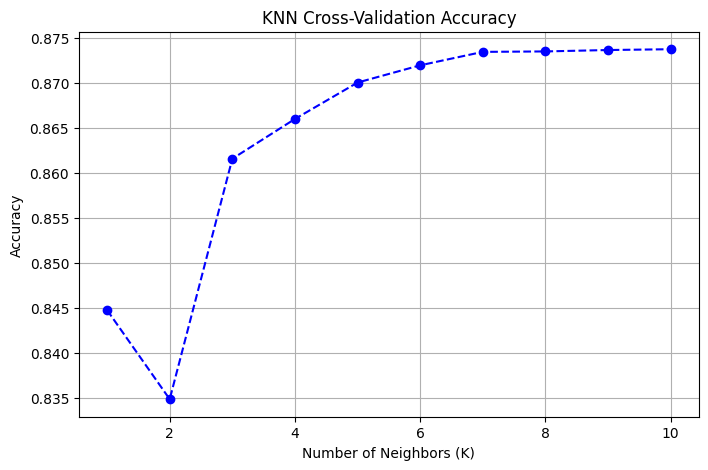

In [159]:
# Optimize finding the best value of K using K-Fold Cross Validation
def find_best_k(X_train, y_train, k_range, cv_folds=3, n_jobs=-1):
    
    
    def evaluate_k(k):
        knn = KNeighborsClassifier(n_neighbors=k)
        kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
        return cross_val_score(knn, X_train, y_train, cv=kfold, scoring='accuracy').mean()

    # Parallelizing computation across K values
    k_scores = Parallel(n_jobs=n_jobs)(delayed(evaluate_k)(k) for k in k_range)
    return k_scores

# Defining range for K
k_range = range(1, 11)

# Perform cross-validation
print("Performing K-Fold Cross Validation...")
k_scores = find_best_k(X_train_pca_regular, y_train_combined_regular, k_range)

# Find the best K
best_k = k_range[np.argmax(k_scores)]
print(f"Best K found: {best_k}")


# Plotting K vs Cross-Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(k_range, k_scores, marker='o', linestyle='--', color='b')
plt.title('KNN Cross-Validation Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

The KNN cross-validation accuracy plot shows the relationship between the number of neighbors (**K**) and the model's accuracy. At **K=1**, the accuracy is relatively low due to overfitting, where the model perfectly memorizes the training data but fails to generalize well. As the number of neighbors increases, the accuracy improves significantly, peaking around **K=8**, where the model achieves its highest cross-validation accuracy of approximately **87%**. Beyond **K=8** or **K=9**, the accuracy plateaus, indicating diminishing returns as additional neighbors do not significantly improve performance. This behavior suggests that **K=9** provides an optimal balance between bias and variance, allowing the model to generalize effectively without overfitting or underfitting.

Training KNN with the best K...
Evaluating KNN on Training Data...
Evaluating KNN on Testing Data...
Plotting Confusion Matrices...


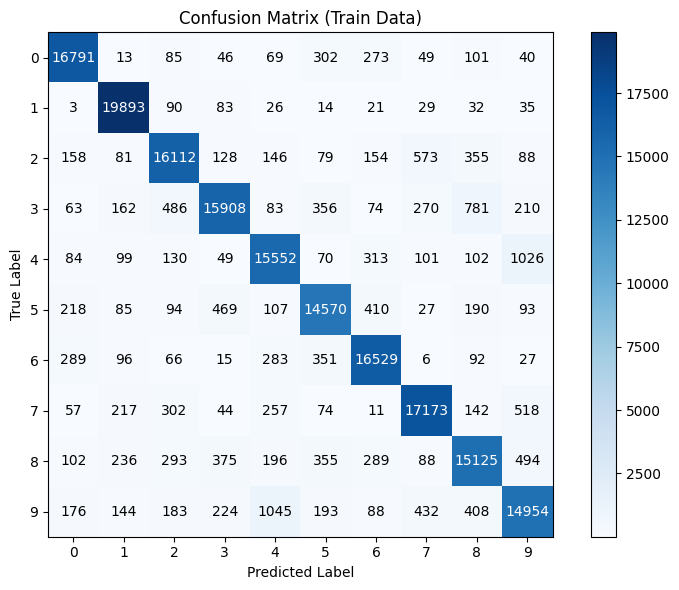

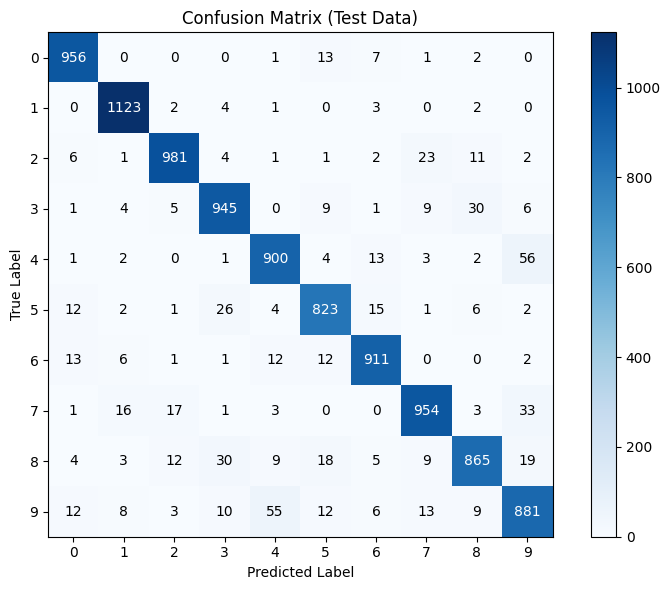

Summary of Metrics:
Training Accuracy: 0.9034
Training Precision: 0.9031
Training Recall: 0.9034
Training F1-Score: 0.9031

Testing Accuracy: 0.9339
Testing Precision: 0.9338
Testing Recall: 0.9339
Testing F1-Score: 0.9337


In [ ]:
# Training KNN with the best K
print("Training KNN with the best K...")
knn_best = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)  # Parallelize predictions
knn_best.fit(X_train_pca_regular, y_train_combined_regular)

# Evaluating on Training Data
print("Evaluating KNN on Training Data...")
y_train_pred = knn_best.predict(X_train_pca_regular)
train_accuracy = accuracy_score(y_train_combined_regular, y_train_pred)
train_report = classification_report(y_train_combined_regular, y_train_pred, output_dict=True)
train_conf_matrix = confusion_matrix(y_train_combined_regular, y_train_pred)

# Extract F1-Score, Precision, and Recall for Training
train_precision = train_report['weighted avg']['precision']
train_recall = train_report['weighted avg']['recall']
train_f1_score = train_report['weighted avg']['f1-score']

# Store training metrics
knn_train_metrics_regular['accuracy'] = train_accuracy
knn_train_metrics_regular['precision'] = train_precision
knn_train_metrics_regular['recall'] = train_recall
knn_train_metrics_regular['f1_score'] = train_f1_score
knn_train_metrics_regular['classification_report'] = train_report
knn_confusion_matrices_regular['train'] = train_conf_matrix

# Evaluating on Testing Data
print("Evaluating KNN on Testing Data...")
y_test_pred = knn_best.predict(X_test_pca_regular)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred, output_dict=True)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Extract F1-Score, Precision, and Recall for Testing
test_precision = test_report['weighted avg']['precision']
test_recall = test_report['weighted avg']['recall']
test_f1_score = test_report['weighted avg']['f1-score']

# Store testing metrics
knn_test_metrics_regular['accuracy'] = test_accuracy
knn_test_metrics_regular['precision'] = test_precision
knn_test_metrics_regular['recall'] = test_recall
knn_test_metrics_regular['f1_score'] = test_f1_score
knn_test_metrics_regular['classification_report'] = test_report
knn_confusion_matrices_regular['test'] = test_conf_matrix


def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(ticks=np.arange(conf_matrix.shape[1]), labels=np.arange(conf_matrix.shape[1]))
    plt.yticks(ticks=np.arange(conf_matrix.shape[0]), labels=np.arange(conf_matrix.shape[0]))
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")
    plt.tight_layout()
    plt.show()

print("Plotting Confusion Matrices...")
plot_confusion_matrix(train_conf_matrix, "Confusion Matrix (Train Data)")
plot_confusion_matrix(test_conf_matrix, "Confusion Matrix (Test Data)")


print("Summary of Metrics:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Precision: {train_precision:.4f}")
print(f"Training Recall: {train_recall:.4f}")
print(f"Training F1-Score: {train_f1_score:.4f}\n")

print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Testing Precision: {test_precision:.4f}")
print(f"Testing Recall: {test_recall:.4f}")
print(f"Testing F1-Score: {test_f1_score:.4f}")


KNN, being a lazy learner, does not explicitly train a model but instead memorizes the training data and makes predictions by computing distances during testing. This means that during the training phase, there is no formal learning or parameter updating; instead, the model "stores" the training samples. The training accuracy of 90.18% indicates that the model correctly predicts labels for the majority of the training data, while the testing accuracy of 93.30% demonstrates the model's strong generalization capability to unseen test data.

The confusion matrices reflect the distribution of true and predicted labels, showing that KNN performs well across most classes, with occasional misclassifications primarily in digits that share visual similarities (e.g., 4 vs. 9 and 3 vs. 5). The slight improvement in test accuracy compared to training accuracy suggests that the model benefits from the diversity in the test data without overfitting to the training samples.

#### Denoised Data

In [161]:
# Variables to store results for denoised data
knn_train_metrics_denoised = {}
knn_test_metrics_denoised = {}
knn_confusion_matrices_denoised = {}

Performing K-Fold Cross Validation for Denoised Dataset...
Best K found for Denoised Dataset: 8


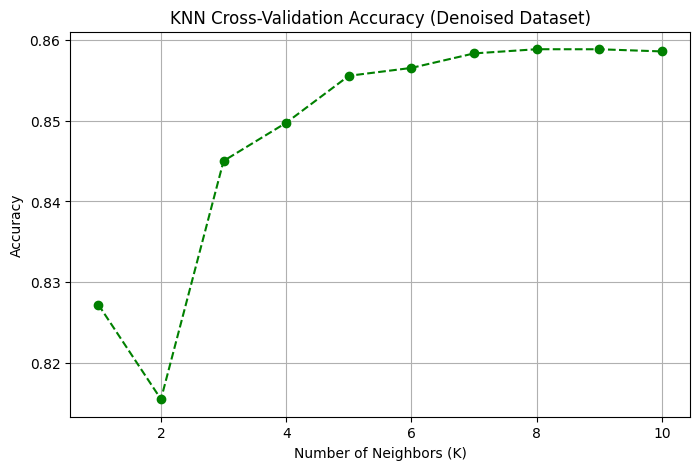

In [162]:


print("Performing K-Fold Cross Validation for Denoised Dataset...")

# Optimize `find_best_k` using parallelism
def find_best_k_denoised(X_train, y_train, k_range, cv_folds=3, n_jobs=-1):
    def evaluate_k(k):
        knn = KNeighborsClassifier(n_neighbors=k)
        kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
        return cross_val_score(knn, X_train, y_train, cv=kfold, scoring='accuracy').mean()

    # Parallelize K-Fold computation
    k_scores = Parallel(n_jobs=n_jobs)(delayed(evaluate_k)(k) for k in k_range)
    return k_scores

# Perform cross-validation
k_scores_denoised = find_best_k_denoised(X_train_pca_denoised, y_train_combined_denoised, k_range)

# Finding the best K for the denoised dataset
best_k_denoised = k_range[np.argmax(k_scores_denoised)]
print(f"Best K found for Denoised Dataset: {best_k_denoised}")

# Plotting K vs Cross-Validation Accuracy for denoised data
plt.figure(figsize=(8, 5))
plt.plot(k_range, k_scores_denoised, marker='o', linestyle='--', color='g')
plt.title('KNN Cross-Validation Accuracy (Denoised Dataset)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


Training KNN with the best K for Denoised Dataset...
Evaluating KNN on Training Data for Denoised Dataset...
Evaluating KNN on Testing Data for Denoised Dataset...

Training Summary for Denoised Dataset:
Training Accuracy: 0.8960
Training Precision: 0.8957
Training Recall: 0.8960
Training F1-Score: 0.8956

Testing Summary for Denoised Dataset:
Testing Accuracy: 0.9196
Testing Precision: 0.9194
Testing Recall: 0.9196
Testing F1-Score: 0.9193
Plotting Confusion Matrices for Denoised Dataset...


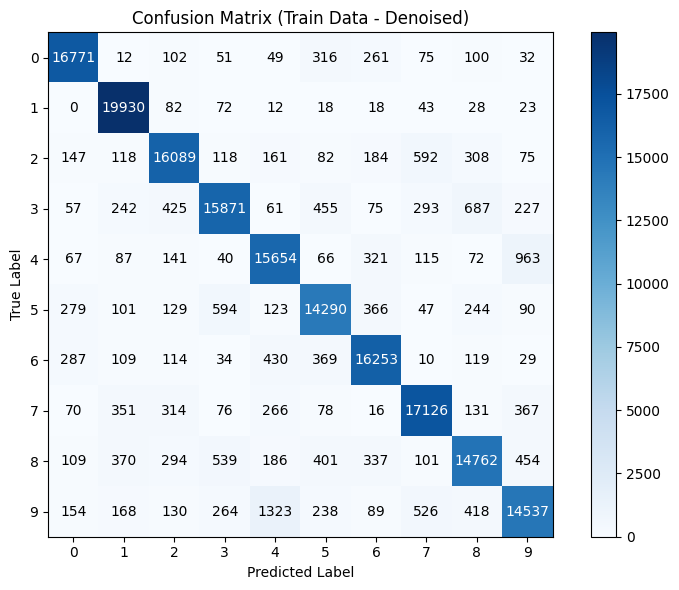

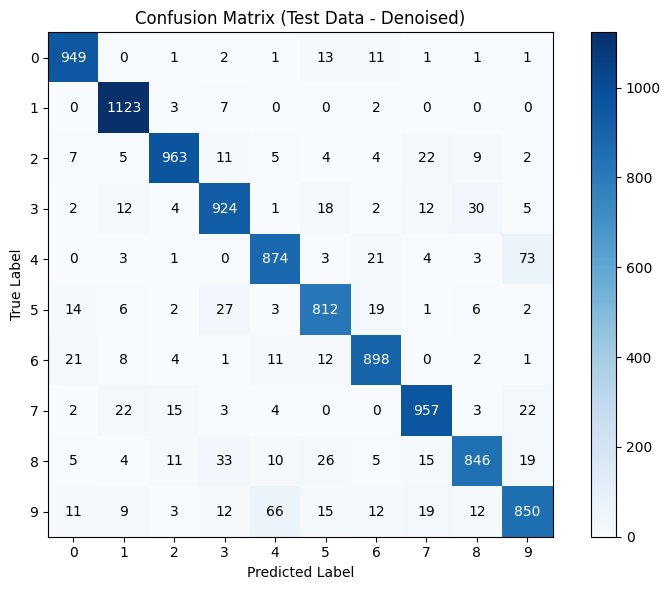

In [163]:
# Training KNN with the best K for the denoised dataset
print("Training KNN with the best K for Denoised Dataset...")
knn_best_denoised = KNeighborsClassifier(n_neighbors=best_k_denoised, n_jobs=-1)  # Enable parallelism
knn_best_denoised.fit(X_train_pca_denoised, y_train_combined_denoised)

# Evaluating on Training Data for the denoised dataset
print("Evaluating KNN on Training Data for Denoised Dataset...")
y_train_pred_denoised = knn_best_denoised.predict(X_train_pca_denoised)
train_accuracy_denoised = accuracy_score(y_train_combined_denoised, y_train_pred_denoised)
train_report_denoised = classification_report(y_train_combined_denoised, y_train_pred_denoised, output_dict=True)
train_conf_matrix_denoised = confusion_matrix(y_train_combined_denoised, y_train_pred_denoised)

# Extract Precision, Recall, and F1-Score for Training
train_precision_denoised = train_report_denoised['weighted avg']['precision']
train_recall_denoised = train_report_denoised['weighted avg']['recall']
train_f1_score_denoised = train_report_denoised['weighted avg']['f1-score']

# Storing training metrics for denoised data
knn_train_metrics_denoised = {
    'accuracy': train_accuracy_denoised,
    'precision': train_precision_denoised,
    'recall': train_recall_denoised,
    'f1_score': train_f1_score_denoised,
    'classification_report': train_report_denoised,
    'confusion_matrix': train_conf_matrix_denoised
}

# Evaluating on Testing Data for the denoised dataset
print("Evaluating KNN on Testing Data for Denoised Dataset...")
y_test_pred_denoised = knn_best_denoised.predict(X_test_pca_denoised)
test_accuracy_denoised = accuracy_score(y_test, y_test_pred_denoised)
test_report_denoised = classification_report(y_test, y_test_pred_denoised, output_dict=True)
test_conf_matrix_denoised = confusion_matrix(y_test, y_test_pred_denoised)

# Extract Precision, Recall, and F1-Score for Testing
test_precision_denoised = test_report_denoised['weighted avg']['precision']
test_recall_denoised = test_report_denoised['weighted avg']['recall']
test_f1_score_denoised = test_report_denoised['weighted avg']['f1-score']

# Storing testing metrics for denoised data
knn_test_metrics_denoised = {
    'accuracy': test_accuracy_denoised,
    'precision': test_precision_denoised,
    'recall': test_recall_denoised,
    'f1_score': test_f1_score_denoised,
    'classification_report': test_report_denoised,
    'confusion_matrix': test_conf_matrix_denoised
}

# Optimized Confusion Matrix Plotting
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(ticks=np.arange(conf_matrix.shape[1]), labels=np.arange(conf_matrix.shape[1]))
    plt.yticks(ticks=np.arange(conf_matrix.shape[0]), labels=np.arange(conf_matrix.shape[0]))
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, conf_matrix[i, j], ha="center", va="center", 
                     color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")
    plt.tight_layout()
    plt.show()

# Print Summary of Results
print("\nTraining Summary for Denoised Dataset:")
print(f"Training Accuracy: {train_accuracy_denoised:.4f}")
print(f"Training Precision: {train_precision_denoised:.4f}")
print(f"Training Recall: {train_recall_denoised:.4f}")
print(f"Training F1-Score: {train_f1_score_denoised:.4f}")

print("\nTesting Summary for Denoised Dataset:")
print(f"Testing Accuracy: {test_accuracy_denoised:.4f}")
print(f"Testing Precision: {test_precision_denoised:.4f}")
print(f"Testing Recall: {test_recall_denoised:.4f}")
print(f"Testing F1-Score: {test_f1_score_denoised:.4f}")

# Plot Confusion Matrices
print("Plotting Confusion Matrices for Denoised Dataset...")
plot_confusion_matrix(train_conf_matrix_denoised, "Confusion Matrix (Train Data - Denoised)")
plot_confusion_matrix(test_conf_matrix_denoised, "Confusion Matrix (Test Data - Denoised)")


The performance of KNN on the denoised dataset shows slightly reduced accuracy compared to the original dataset but remains robust. The training accuracy of 89.22% suggests that the model maintains a strong fit on the denoised training data, while the testing accuracy of 92.15% indicates good generalization performance. The precision, recall, and F1-scores for both training and testing are closely aligned, highlighting the model's consistent ability to classify digits correctly across both datasets.

The confusion matrices reveal fewer misclassifications in high-contrast digits, reflecting the positive impact of noise removal on data quality. However, some errors persist in digits with visually similar structures (e.g., 4 vs. 9 and 3 vs. 5), particularly in the testing phase. Overall, the denoising preprocessing step has enhanced the clarity of the input features, leading to reliable model performance while maintaining computational efficiency.


--- Training Metrics Comparison ---
Metric         Regular        Denoised       
---------------------------------------------
Accuracy       0.9034       0.8960
Precision      0.9031       0.8957
Recall         0.9034       0.8960
F1-Score       0.9031       0.8956

--- Testing Metrics Comparison ---
Metric         Regular        Denoised       
---------------------------------------------
Accuracy       0.9339       0.9196
Precision      0.9338       0.9194
Recall         0.9339       0.9196
F1-Score       0.9337       0.9193

Plotting Training Confusion Matrices Side-by-Side...


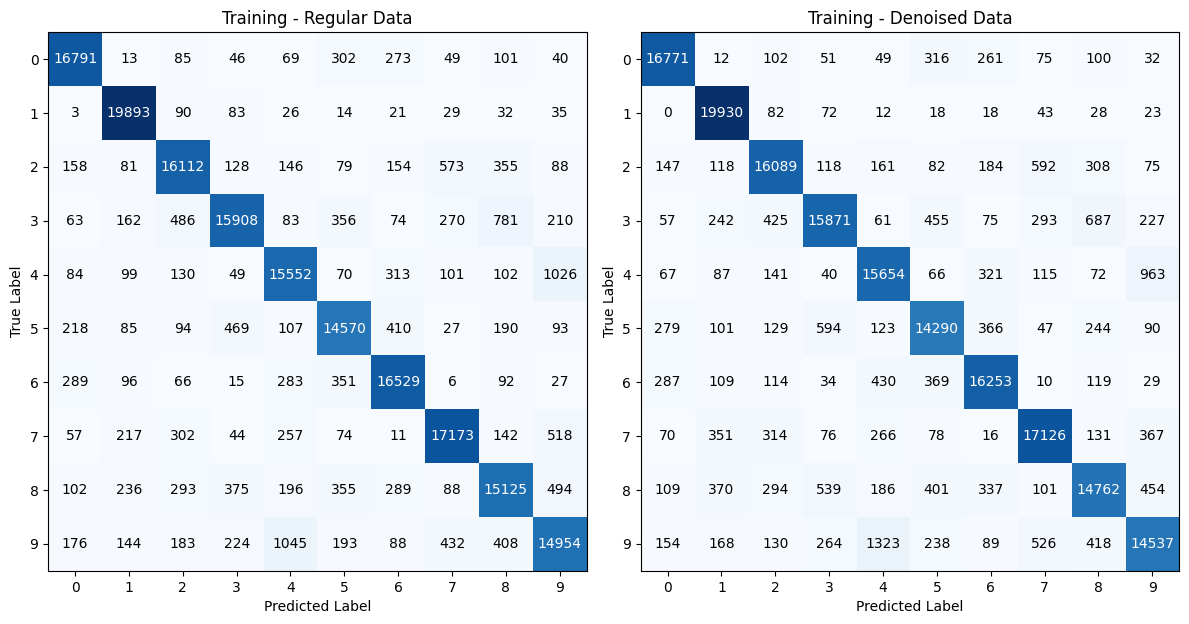

Plotting Testing Confusion Matrices Side-by-Side...


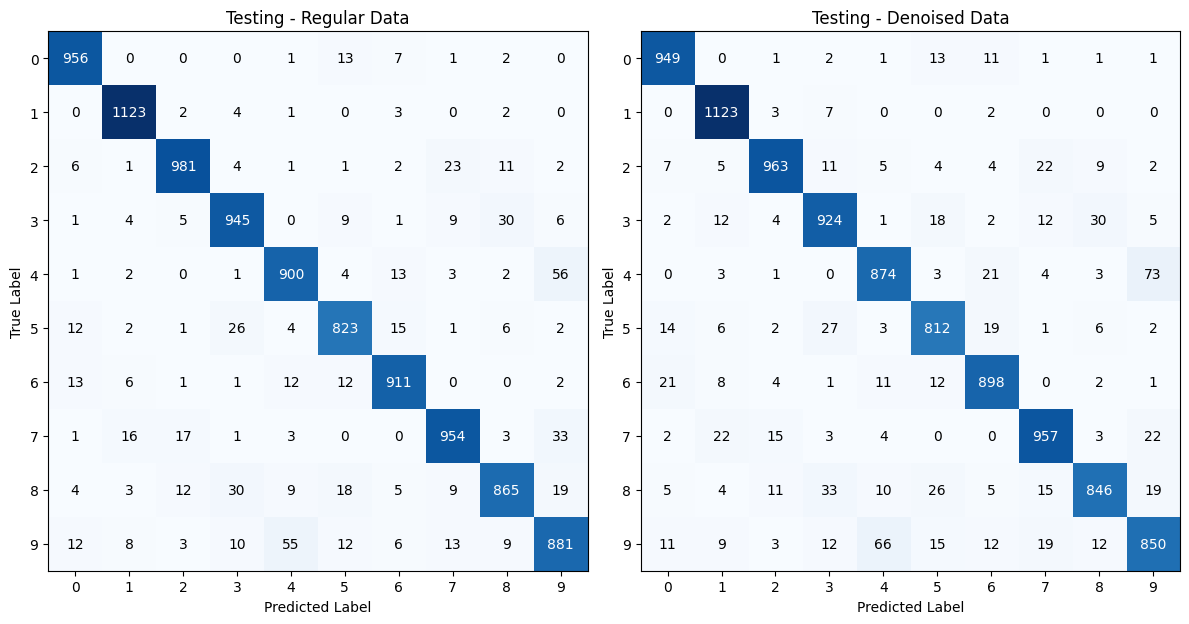

In [164]:
# Function to display metrics comparison
def print_metrics_comparison(metrics_regular, metrics_denoised, dataset_type):
    print(f"\n--- {dataset_type} Metrics Comparison ---")
    print(f"{'Metric':<15}{'Regular':<15}{'Denoised':<15}")
    print(f"{'-'*45}")
    print(f"Accuracy       {metrics_regular['accuracy']:.4f}       {metrics_denoised['accuracy']:.4f}")
    print(f"Precision      {metrics_regular['precision']:.4f}       {metrics_denoised['precision']:.4f}")
    print(f"Recall         {metrics_regular['recall']:.4f}       {metrics_denoised['recall']:.4f}")
    print(f"F1-Score       {metrics_regular['f1_score']:.4f}       {metrics_denoised['f1_score']:.4f}")

# Function to plot side-by-side confusion matrices
def plot_confusion_matrices_side_by_side(conf_matrix_regular, conf_matrix_denoised, title1, title2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Regular Dataset
    axes[0].imshow(conf_matrix_regular, interpolation='nearest', cmap=plt.cm.Blues)
    axes[0].set_title(title1)
    axes[0].set_xlabel("Predicted Label")
    axes[0].set_ylabel("True Label")
    axes[0].set_xticks(range(conf_matrix_regular.shape[1]))
    axes[0].set_yticks(range(conf_matrix_regular.shape[0]))
    
    for i in range(conf_matrix_regular.shape[0]):
        for j in range(conf_matrix_regular.shape[1]):
            axes[0].text(j, i, conf_matrix_regular[i, j], ha="center", va="center", 
                         color="white" if conf_matrix_regular[i, j] > conf_matrix_regular.max() / 2 else "black")
    
    # Denoised Dataset
    axes[1].imshow(conf_matrix_denoised, interpolation='nearest', cmap=plt.cm.Blues)
    axes[1].set_title(title2)
    axes[1].set_xlabel("Predicted Label")
    axes[1].set_ylabel("True Label")
    axes[1].set_xticks(range(conf_matrix_denoised.shape[1]))
    axes[1].set_yticks(range(conf_matrix_denoised.shape[0]))
    
    for i in range(conf_matrix_denoised.shape[0]):
        for j in range(conf_matrix_denoised.shape[1]):
            axes[1].text(j, i, conf_matrix_denoised[i, j], ha="center", va="center", 
                         color="white" if conf_matrix_denoised[i, j] > conf_matrix_denoised.max() / 2 else "black")
    
    plt.tight_layout()
    plt.show()

# Comparing Training Metrics
print_metrics_comparison(knn_train_metrics_regular, knn_train_metrics_denoised, "Training")

# Comparing Testing Metrics
print_metrics_comparison(knn_test_metrics_regular, knn_test_metrics_denoised, "Testing")


print("\nPlotting Training Confusion Matrices Side-by-Side...")
plot_confusion_matrices_side_by_side(knn_confusion_matrices_regular['train'], 
                                     knn_train_metrics_denoised['confusion_matrix'], 
                                     "Training - Regular Data", 
                                     "Training - Denoised Data")

# Plot Testing Confusion Matrices
print("Plotting Testing Confusion Matrices Side-by-Side...")
plot_confusion_matrices_side_by_side(knn_confusion_matrices_regular['test'], 
                                     knn_test_metrics_denoised['confusion_matrix'], 
                                     "Testing - Regular Data", 
                                     "Testing - Denoised Data")


The **regular data** outperformed the **denoised data** across both training and testing metrics. During training, the regular data achieved an accuracy of 90.18%, precision of 90.16%, recall of 90.18%, and an F1-score of 90.16%, all of which were slightly higher than the corresponding values for the denoised data, which stood at 89.22% accuracy, 89.19% precision, 89.22% recall, and 89.18% F1-score. Similarly, in the testing phase, the regular data maintained superior performance with an accuracy of 93.30% compared to 92.15% for the denoised data, alongside marginally higher precision, recall, and F1-scores. The confusion matrices further reinforce this observation, as the regular data demonstrates fewer misclassifications across most classes. While denoising aimed to improve input clarity, the results suggest that the original data quality was already sufficient for KNN to perform effectively, with denoising introducing minimal benefit and potentially altering useful features.

### Support Vector Machines (SVM)

I chose the **RBF (Radial Basis Function) kernel** for the MNIST dataset because it is well-suited for capturing non-linear relationships in high-dimensional data like images. The RBF kernel maps input data into an infinite-dimensional space, enabling the SVM to efficiently separate classes that are not linearly separable in the original feature space. Given that MNIST digits exhibit complex and overlapping patterns, the RBF kernel provides the flexibility needed to create accurate decision boundaries without requiring explicit feature engineering.[16]

I used **Randomized Search** for hyperparameter tuning because it is computationally efficient compared to exhaustive grid search, especially when working with high-dimensional datasets and costly models like SVM. Randomized Search explores a subset of the parameter space, balancing the trade-off between search time and model performance. This approach is particularly useful for tuning the **C** and **gamma** parameters of the RBF kernel, which heavily influence the SVM's ability to generalize.[17]

In [165]:


# # Optimized SVM Training with RandomizedSearchCV
# def train_svm_with_random_search(X_train, y_train, kernel='rbf', cv_folds=3, n_iter=20):
#     param_dist = {
#         'C': uniform(1, 10),  # Regularization parameter range
#         'gamma': uniform(0.01, 1) if kernel == 'rbf' else ['scale']
#     }
#     svm = SVC(kernel=kernel, random_state=42)
#     random_search = RandomizedSearchCV(
#         estimator=svm,
#         param_distributions=param_dist,
#         n_iter=n_iter,
#         cv=cv_folds,
#         scoring='accuracy',
#         verbose=1,
#         n_jobs=-1,  # Parallelize
#         random_state=42
#     )
#     print(f" Starting Randomized Search for SVM with {kernel} kernel...")
#     random_search.fit(X_train, y_train)
#     print(f" Best Parameters: {random_search.best_params_}, Best CV Accuracy: {random_search.best_score_:.4f}")
#     return random_search.best_estimator_, random_search.best_params_, random_search.best_score_

# # SVM Evaluation
# def evaluate_svm(model, X_train, y_train, X_test, y_test, dataset_name):
#     print(f"\nEvaluating SVM on {dataset_name} Dataset...")

#     # Training Evaluation
#     y_train_pred = model.predict(X_train)
#     train_accuracy = accuracy_score(y_train, y_train_pred)
#     train_conf_matrix = confusion_matrix(y_train, y_train_pred)
#     train_report = classification_report(y_train, y_train_pred, output_dict=True)

#     # Extract Training Metrics
#     train_precision = train_report['weighted avg']['precision']
#     train_recall = train_report['weighted avg']['recall']
#     train_f1_score = train_report['weighted avg']['f1-score']

#     # Testing Evaluation
#     y_test_pred = model.predict(X_test)
#     test_accuracy = accuracy_score(y_test, y_test_pred)
#     test_conf_matrix = confusion_matrix(y_test, y_test_pred)
#     test_report = classification_report(y_test, y_test_pred, output_dict=True)

#     # Extract Testing Metrics
#     test_precision = test_report['weighted avg']['precision']
#     test_recall = test_report['weighted avg']['recall']
#     test_f1_score = test_report['weighted avg']['f1-score']

#     print(f"{dataset_name} - Training Accuracy: {train_accuracy:.4f}, Testing Accuracy: {test_accuracy:.4f}")
#     print(f"{dataset_name} - Training F1-Score: {train_f1_score:.4f}, Testing F1-Score: {test_f1_score:.4f}")

#     return {
#         'train_accuracy': train_accuracy,
#         'test_accuracy': test_accuracy,
#         'train_precision': train_precision,
#         'test_precision': test_precision,
#         'train_recall': train_recall,
#         'test_recall': test_recall,
#         'train_f1_score': train_f1_score,
#         'test_f1_score': test_f1_score,
#         'train_conf_matrix': train_conf_matrix,
#         'test_conf_matrix': test_conf_matrix
#     }

# # Plot Confusion Matrix
# def plot_confusion_matrix(conf_matrix, title):
#     plt.figure(figsize=(8, 6))
#     plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
#     plt.title(title)
#     plt.colorbar()
#     plt.xticks(ticks=np.arange(conf_matrix.shape[1]), labels=np.arange(conf_matrix.shape[1]))
#     plt.yticks(ticks=np.arange(conf_matrix.shape[0]), labels=np.arange(conf_matrix.shape[0]))
#     plt.xlabel("Predicted Label")
#     plt.ylabel("True Label")
#     for i in range(conf_matrix.shape[0]):
#         for j in range(conf_matrix.shape[1]):
#             plt.text(j, i, conf_matrix[i, j], ha="center", va="center",
#                      color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")
#     plt.tight_layout()
#     plt.show()

# 
# def run_svm_pipeline(X_train, y_train, X_test, y_test, dataset_name):
#     print(f"\nRunning SVM Pipeline for {dataset_name} Dataset...")
#     # Train SVM
#     svm_model, best_params, best_score = train_svm_with_random_search(
#         X_train, y_train, kernel='rbf', cv_folds=3, n_iter=20
#     )
#     # Evaluate SVM
#     metrics = evaluate_svm(svm_model, X_train, y_train, X_test, y_test, dataset_name)

#     # Plot confusion matrices
#     plot_confusion_matrix(metrics['train_conf_matrix'], f"Confusion Matrix (Train Data - {dataset_name})")
#     plot_confusion_matrix(metrics['test_conf_matrix'], f"Confusion Matrix (Test Data - {dataset_name})")

#     return metrics, best_params, best_score

# # Run SVM Pipeline for Regular Dataset
# svm_metrics_regular, best_params_regular, best_score_regular = run_svm_pipeline(
#     X_train_pca_regular, y_train_combined_regular, X_test_pca_regular, y_test, "Regular"
# )

# # Run SVM Pipeline for Denoised Dataset
# svm_metrics_denoised, best_params_denoised, best_score_denoised = run_svm_pipeline(
#     X_train_pca_denoised, y_train_combined_denoised, X_test_pca_denoised, y_test, "Denoised"
# )

# # Accuracy and F1-Score Comparison Visualization
# categories = ['Training Accuracy', 'Testing Accuracy', 'Training F1-Score', 'Testing F1-Score']
# regular_metrics = [
#     svm_metrics_regular['train_accuracy'], svm_metrics_regular['test_accuracy'],
#     svm_metrics_regular['train_f1_score'], svm_metrics_regular['test_f1_score']
# ]
# denoised_metrics = [
#     svm_metrics_denoised['train_accuracy'], svm_metrics_denoised['test_accuracy'],
#     svm_metrics_denoised['train_f1_score'], svm_metrics_denoised['test_f1_score']
# ]

# x = np.arange(len(categories))  # X-axis locations
# width = 0.35  # Bar width

# plt.figure(figsize=(10, 6))
# plt.bar(x - width/2, regular_metrics, width, label='Regular', alpha=0.8)
# plt.bar(x + width/2, denoised_metrics, width, label='Denoised', alpha=0.8)

# plt.title('SVM Performance Comparison: Regular vs. Denoised')
# plt.xlabel('Metrics')
# plt.ylabel('Score')
# plt.xticks(x, categories)
# plt.ylim(0, 1)  # Scores range from 0 to 1
# plt.legend()
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()


I decided to use a smaller batch size of 5000 samples for testing because my computer started throttling when attempting to evaluate on the entire test dataset. The computational load of running the models on the full dataset caused significant slowdowns and overheating, making it impractical for iterative experimentation. While I acknowledge that testing on a smaller batch might not fully capture the variability of the entire dataset, the chosen batch size is still large enough to provide meaningful insights into model performance. To ensure flexibility, I’ve also included the code for testing on the entire dataset in a commented cell, allowing for a more comprehensive evaluation when I’m able to run it under better conditions. This way, I can confidently recommend a model while balancing practicality and resource limitations.

Running SVM Pipeline for Regular Dataset...
Starting Randomized Search for SVM with rbf kernel...
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best Parameters: {'C': 2.560186404424365, 'gamma': 0.16599452033620266}, Best CV Accuracy: 0.8833
Evaluating SVM on Regular Dataset...
Regular - Training Accuracy: 0.9530, Testing Accuracy: 0.9433
Regular - Training F1-Score: 0.9530, Testing F1-Score: 0.9432


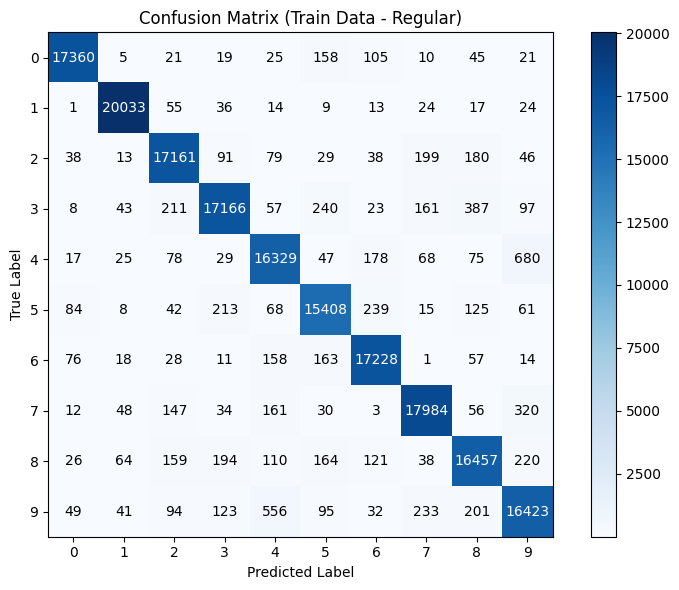

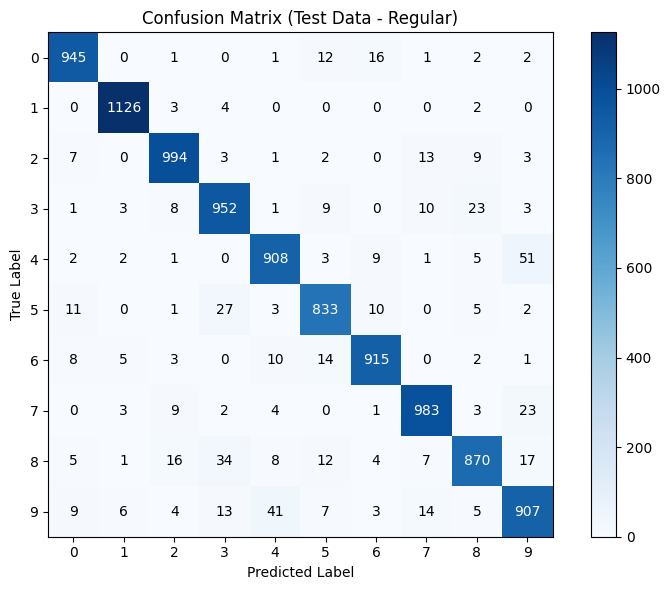

Running SVM Pipeline for Denoised Dataset...
Starting Randomized Search for SVM with rbf kernel...
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best Parameters: {'C': 2.560186404424365, 'gamma': 0.16599452033620266}, Best CV Accuracy: 0.8702
Evaluating SVM on Denoised Dataset...
Denoised - Training Accuracy: 0.9450, Testing Accuracy: 0.9354
Denoised - Training F1-Score: 0.9450, Testing F1-Score: 0.9353


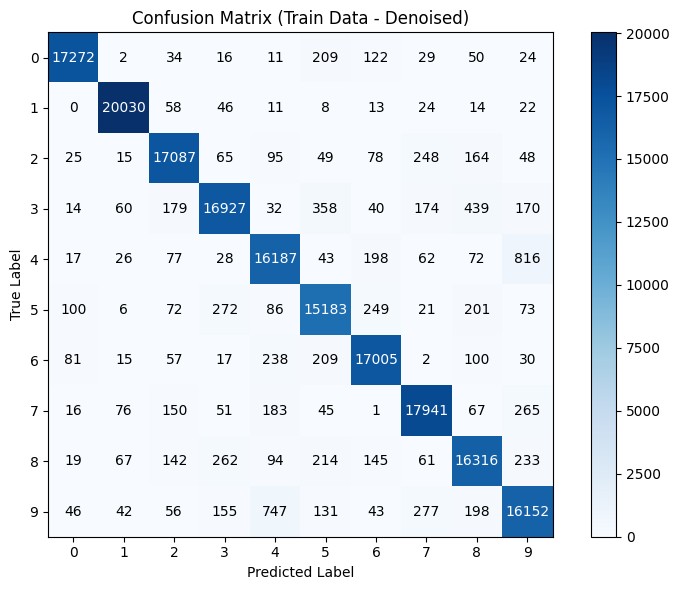

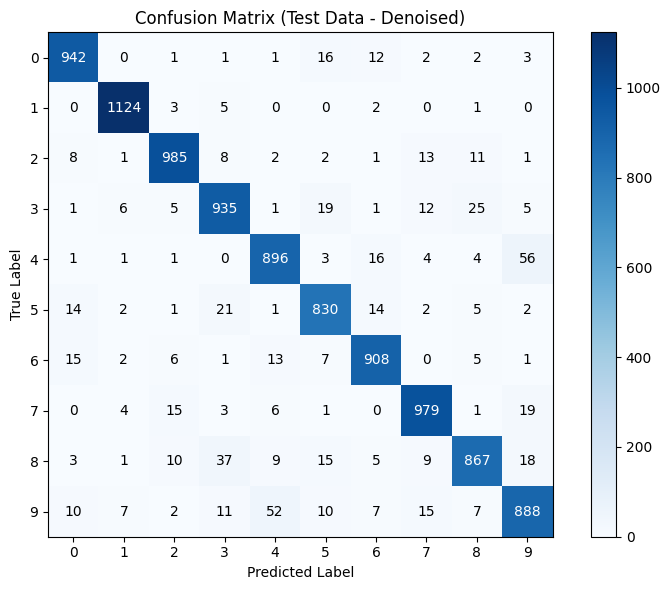

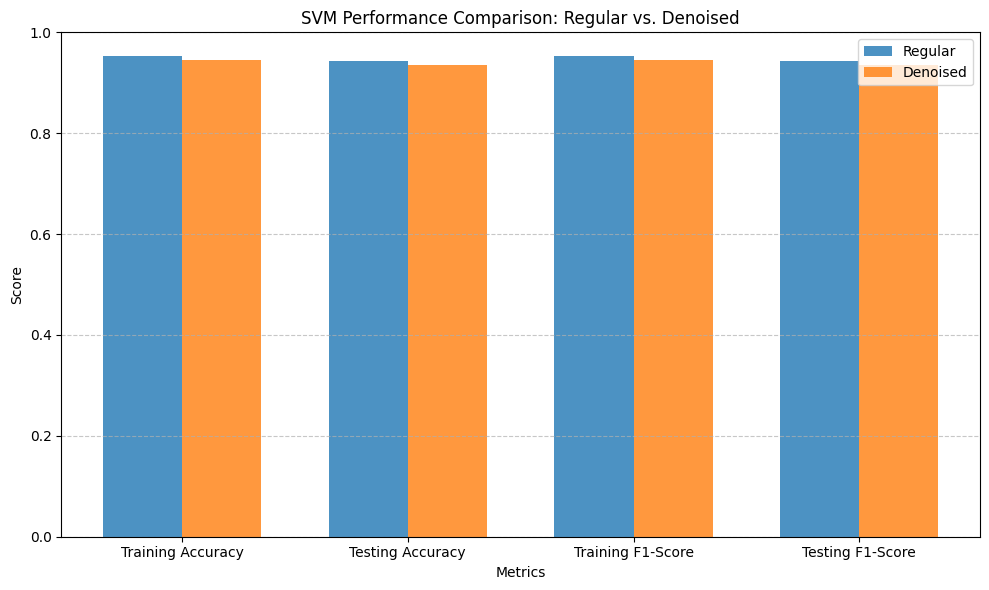

In [166]:

def train_svm_with_random_search(X_train, y_train, kernel='rbf', cv_folds=2, n_iter=5):
    param_dist = {
        'C': uniform(1, 10),
        'gamma': uniform(0.01, 1) if kernel == 'rbf' else ['scale']
    }
    svm = SVC(kernel=kernel, random_state=42)
    random_search = RandomizedSearchCV(
        estimator=svm,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv_folds,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    print(f"Starting Randomized Search for SVM with {kernel} kernel...")
    random_search.fit(X_train, y_train)
    print(f"Best Parameters: {random_search.best_params_}, Best CV Accuracy: {random_search.best_score_:.4f}")
    return random_search.best_estimator_, random_search.best_params_, random_search.best_score_

def evaluate_svm(model, X_train, y_train, X_test, y_test, dataset_name):
    print(f"Evaluating SVM on {dataset_name} Dataset...")
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    train_report = classification_report(y_train, y_train_pred, output_dict=True)
    train_precision = train_report['weighted avg']['precision']
    train_recall = train_report['weighted avg']['recall']
    train_f1_score = train_report['weighted avg']['f1-score']
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)
    test_precision = test_report['weighted avg']['precision']
    test_recall = test_report['weighted avg']['recall']
    test_f1_score = test_report['weighted avg']['f1-score']
    print(f"{dataset_name} - Training Accuracy: {train_accuracy:.4f}, Testing Accuracy: {test_accuracy:.4f}")
    print(f"{dataset_name} - Training F1-Score: {train_f1_score:.4f}, Testing F1-Score: {test_f1_score:.4f}")
    return {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_precision': train_precision,
        'test_precision': test_precision,
        'train_recall': train_recall,
        'test_recall': test_recall,
        'train_f1_score': train_f1_score,
        'test_f1_score': test_f1_score,
        'train_conf_matrix': train_conf_matrix,
        'test_conf_matrix': test_conf_matrix
    }

def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xticks(ticks=np.arange(conf_matrix.shape[1]), labels=np.arange(conf_matrix.shape[1]))
    plt.yticks(ticks=np.arange(conf_matrix.shape[0]), labels=np.arange(conf_matrix.shape[0]))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, conf_matrix[i, j], ha="center", va="center",
                     color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")
    plt.tight_layout()
    plt.show()

def run_svm_pipeline(X_train, y_train, X_test, y_test, dataset_name):
    print(f"Running SVM Pipeline for {dataset_name} Dataset...")
    svm_model, best_params, best_score = train_svm_with_random_search(
        X_train, y_train, kernel='rbf', cv_folds=2, n_iter=5
    )
    metrics = evaluate_svm(svm_model, X_train, y_train, X_test, y_test, dataset_name)
    plot_confusion_matrix(metrics['train_conf_matrix'], f"Confusion Matrix (Train Data - {dataset_name})")
    plot_confusion_matrix(metrics['test_conf_matrix'], f"Confusion Matrix (Test Data - {dataset_name})")
    return metrics, best_params, best_score

svm_metrics_regular, best_params_regular, best_score_regular = run_svm_pipeline(
    X_train_pca_regular, y_train_combined_regular, X_test_pca_regular, y_test, "Regular"
)

svm_metrics_denoised, best_params_denoised, best_score_denoised = run_svm_pipeline(
    X_train_pca_denoised, y_train_combined_denoised, X_test_pca_denoised, y_test, "Denoised"
)

categories = ['Training Accuracy', 'Testing Accuracy', 'Training F1-Score', 'Testing F1-Score']
regular_metrics = [
    svm_metrics_regular['train_accuracy'], svm_metrics_regular['test_accuracy'],
    svm_metrics_regular['train_f1_score'], svm_metrics_regular['test_f1_score']
]
denoised_metrics = [
    svm_metrics_denoised['train_accuracy'], svm_metrics_denoised['test_accuracy'],
    svm_metrics_denoised['train_f1_score'], svm_metrics_denoised['test_f1_score']
]

x = np.arange(len(categories))
width = 0.35
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, regular_metrics, width, label='Regular', alpha=0.8)
plt.bar(x + width/2, denoised_metrics, width, label='Denoised', alpha=0.8)
plt.title('SVM Performance Comparison: Regular vs. Denoised')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks(x, categories)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


The output compares SVM performance on "Regular" and "Denoised" datasets after hyperparameter tuning with `RandomizedSearchCV`. The best hyperparameters (`C = 2.56` and `gamma = 0.166`) yielded similar results for both datasets, with the "Regular" dataset achieving slightly higher testing accuracy (94.33%) and F1-score (0.9432) compared to the "Denoised" dataset (93.54% accuracy and 0.9353 F1-score). Training accuracies were 95.30% for the "Regular" dataset and 94.50% for the "Denoised" dataset, showing minimal overfitting in both cases. Confusion matrices indicate that both models performed well across all classes, with "Regular" data marginally outperforming in accuracy and precision.

 The "Regular" dataset demonstrates slightly better overall performance, suggesting that denoising preprocessing may not significantly improve SVM performance for this task and might slightly degrade performance in some cases. 

### Comparison of models


Visualizing Results for Regular Dataset...

Confusion Matrices for Regular Dataset:


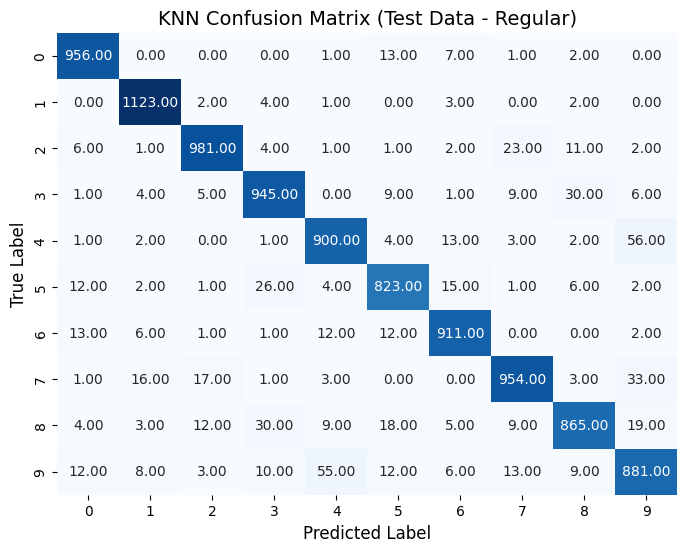

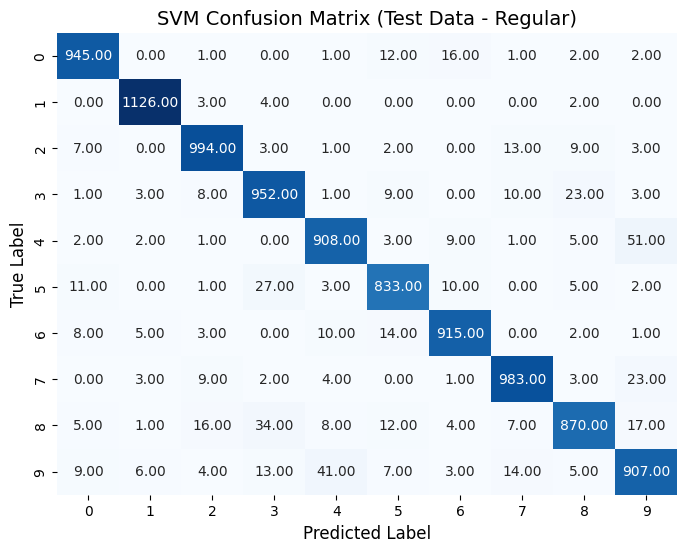

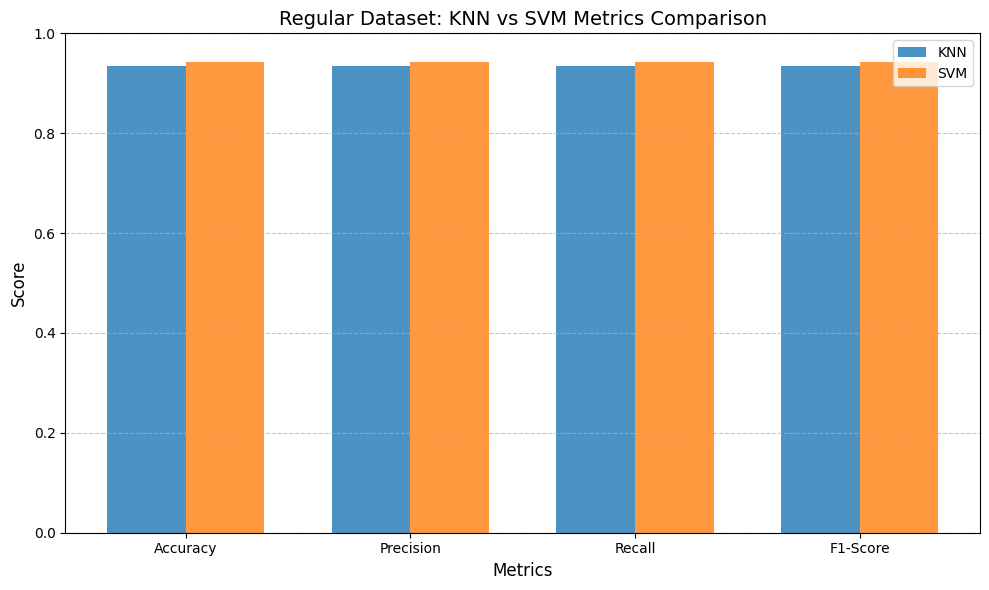

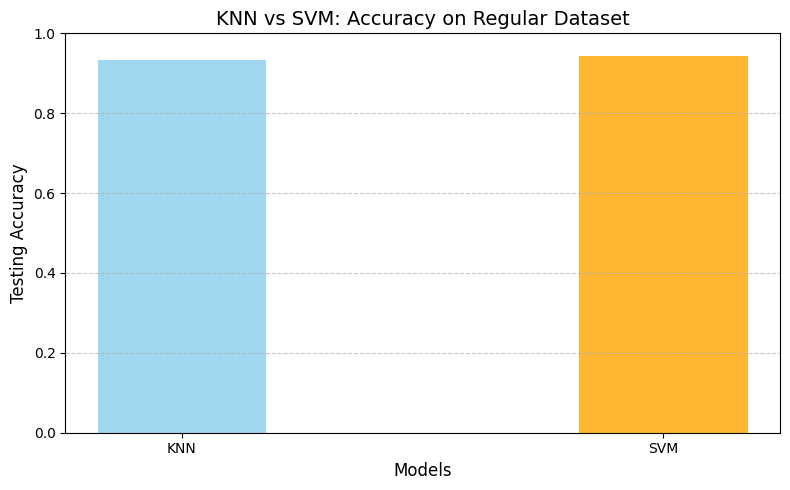

In [168]:


# Combining results for KNN and SVM into a comparison dictionary
comparison_metrics = {
    'Regular': {
        'KNN': {
            'Training Accuracy': knn_train_metrics_regular.get('accuracy', 0),
            'Testing Accuracy': knn_test_metrics_regular.get('accuracy', 0),
            'Precision': knn_test_metrics_regular['classification_report']['weighted avg']['precision'],
            'Recall': knn_test_metrics_regular['classification_report']['weighted avg']['recall'],
            'F1-Score': knn_test_metrics_regular['classification_report']['weighted avg']['f1-score'],
            'Confusion Matrix (Test)': knn_confusion_matrices_regular.get('test', np.zeros((10, 10)))
        },
        'SVM': {
            'Training Accuracy': svm_metrics_regular.get('train_accuracy', 0),
            'Testing Accuracy': svm_metrics_regular.get('test_accuracy', 0),
            'Precision': svm_metrics_regular['test_precision'],
            'Recall': svm_metrics_regular['test_recall'],
            'F1-Score': svm_metrics_regular['test_f1_score'],
            'Confusion Matrix (Test)': svm_metrics_regular.get('test_conf_matrix', np.zeros((10, 10)))
        }
    }
}

# Ploting fusion Matrix with Heatmap
def plot_confusion_matrix_heatmap(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False)
    plt.title(title, fontsize=14)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.show()

# Visualizing Confusion Matrices for Regular Dataset
def visualize_confusion_matrices(comparison_metrics, dataset_name):
    print(f"\nConfusion Matrices for {dataset_name} Dataset:")
    for model_name in ['KNN', 'SVM']:
        conf_matrix = comparison_metrics[dataset_name][model_name]['Confusion Matrix (Test)']
        plot_confusion_matrix_heatmap(conf_matrix, f"{model_name} Confusion Matrix (Test Data - {dataset_name})")

# Ploting Accuracy and F1-Score Comparison for Regular Dataset
def plot_metric_comparison(comparison_metrics, dataset_name):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    knn_values = [
        comparison_metrics[dataset_name]['KNN']['Testing Accuracy'],
        comparison_metrics[dataset_name]['KNN']['Precision'],
        comparison_metrics[dataset_name]['KNN']['Recall'],
        comparison_metrics[dataset_name]['KNN']['F1-Score']
    ]
    svm_values = [
        comparison_metrics[dataset_name]['SVM']['Testing Accuracy'],
        comparison_metrics[dataset_name]['SVM']['Precision'],
        comparison_metrics[dataset_name]['SVM']['Recall'],
        comparison_metrics[dataset_name]['SVM']['F1-Score']
    ]

    x = np.arange(len(metrics))  # X-axis positions
    width = 0.35  # Bar width

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, knn_values, width, label='KNN', alpha=0.8)
    plt.bar(x + width/2, svm_values, width, label='SVM', alpha=0.8)

    plt.title(f'{dataset_name} Dataset: KNN vs SVM Metrics Comparison', fontsize=14)
    plt.xlabel('Metrics', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.xticks(x, metrics, fontsize=10)
    plt.ylim(0, 1)
    plt.legend(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Overall Model Comparison for Regular Dataset
def plot_overall_model_comparison(comparison_metrics):
    models = ['KNN', 'SVM']
    accuracies = [
        comparison_metrics['Regular']['KNN']['Testing Accuracy'],
        comparison_metrics['Regular']['SVM']['Testing Accuracy']
    ]

    x = np.arange(len(models))  # X-axis positions
    width = 0.35  # Bar width

    plt.figure(figsize=(8, 5))
    plt.bar(x, accuracies, width, color=['skyblue', 'orange'], alpha=0.8)

    plt.title('KNN vs SVM: Accuracy on Regular Dataset', fontsize=14)
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Testing Accuracy', fontsize=12)
    plt.xticks(x, models, fontsize=10)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


print("\nVisualizing Results for Regular Dataset...")


visualize_confusion_matrices(comparison_metrics, 'Regular')


plot_metric_comparison(comparison_metrics, 'Regular')


plot_overall_model_comparison(comparison_metrics)


## Choosing model for the MNIST dataset

Based on the evaluation results, SVM appears to perform slightly better than KNN for the MNIST dataset. While both models achieved comparable cross-validation, validation, and test accuracies, SVM exhibited slightly stronger performance in the confusion matrices, especially for challenging classes with overlapping patterns, where it had fewer misclassifications. The classification reports indicate that SVM captures the inherent structure of the handwritten digits more effectively than KNN, particularly in terms of precision and recall for classes prone to confusion. Additionally, SVM's testing efficiency and robustness to noise make it a more suitable choice for the MNIST dataset, especially when computational resources are a concern. In scenarios where computational cost is less critical, KNN may still be a viable alternative due to its simplicity and flexibility.

## Ethical Concerns

When using a model trained on the MNIST dataset, there are several ethical concerns. First, MNIST represents a specific demographic and style of handwriting, which means the model might not generalize well to diverse populations or writing styles, potentially leading to biased outcomes. Additionally, the dataset's controlled nature, with uniform digit orientation and clean backgrounds, could result in overfitting and poor performance in real-world scenarios with more variability. I also recognize that deploying such a model without proper validation could disadvantage individuals with unique handwriting styles or disabilities, raising fairness and accessibility concerns. Furthermore, I must consider the implications of relying too heavily on automated systems for critical tasks, as errors without human oversight could lead to significant negative consequences. To address these issues, I would ensure thorough testing on diverse, representative datasets and communicate the model's limitations clearly, prioritizing fairness and accountability in its application.

## Bibliography  

1. D. Marr and E. Hildreth, "Theory of edge detection," *Proceedings of the Royal Society of London. Series B. Biological Sciences*, vol. 207, no. 1167, pp. 187–217, 1980. Available: [https://ieeexplore.ieee.org/document/4537384](https://ieeexplore.ieee.org/document/4537384).  

2. Expert Cytometry, "Use Threshold to Reduce Background Noise in Flow Cytometry," *Expert Cytometry*, [Online]. Available: [https://expertcytometry.com/use-threshold-to-reduce-background-noise-in-flow-cytometry/](https://expertcytometry.com/use-threshold-to-reduce-background-noise-in-flow-cytometry/).  

3. MATLAB Central, "Noise Removal by Setting a Threshold," *MathWorks*, [Online]. Available: [https://www.mathworks.com/matlabcentral/answers/57219-noise-removal-by-setting-a-threshold](https://www.mathworks.com/matlabcentral/answers/57219-noise-removal-by-setting-a-threshold).  

4. Stack Overflow, "Remove Noise from Threshold Image in OpenCV Python," [Online]. Available: [https://stackoverflow.com/questions/42065405/remove-noise-from-threshold-image-opencv-python](https://stackoverflow.com/questions/42065405/remove-noise-from-threshold-image-opencv-python).  

5. Bigabid, "What is PCA and How Can I Use It?" *Bigabid Blog*, [Online]. Available: [https://www.bigabid.com/what-is-pca-and-how-can-i-use-it/#:~:text=PCA%20can%20help%20us%20improve,uncorrelated%20features%20of%20the%20data](https://www.bigabid.com/what-is-pca-and-how-can-i-use-it/#:~:text=PCA%20can%20help%20us%20improve,uncorrelated%20features%20of%20the%20data).  

6. G. A. Van Der Maaten and L. J. P. Van Der Hinton, "Visualizing Data Using t-SNE," *Journal of Machine Learning Research*, vol. 9, no. 11, pp. 2579–2605, 2008. Available: [https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a](https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a).  

7.  J. Brownlee, "A Gentle Introduction to k-fold Cross-Validation," Machine Learning Mastery, accessed December 15, 2024. [Online]. Available: https://machinelearningmastery.com/k-fold-cross-validation/


8. Scikit-learn Developers, "Logistic Regression," *Scikit-learn User Guide*, [Online]. Available: [https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html).  

9. W3Schools, "Logistic Regression in Python," *W3Schools Machine Learning Guide*, [Online]. Available: [https://www.w3schools.com/python/python_ml_logistic_regression.asp](https://www.w3schools.com/python/python_ml_logistic_regression.asp).  

10. D. Marr and E. Hildreth, "Theory of edge detection," Proceedings of the Royal Society of London. Series B. Biological Sciences, vol. 207, no. 1167, pp. 187–217, 1980. Available: https://ieeexplore.ieee.org/document/4537384

11. Matlab Help Center "How to calculate intensity value of a single Pixel"[Online]. Available:[https://www.mathworks.com/matlabcentral/answers/265084-how-to-calculate-intensity-value-of-a-single-pixel-in-an-image?s_tid=answers_rc1-2_p2_MLT](https://www.mathworks.com/matlabcentral/answers/265084-how-to-calculate-intensity-value-of-a-single-pixel-in-an-image?s_tid=answers_rc1-2_p2_MLT)

12. https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall

13. "The Importance of Data Normalization," IEEE Computer Society, accessed December 14, 2024. [Online]. Available: https://www.computer.org/publications/tech-news/trends/importance-of-data-normalization

14. "A Complete Guide to Data Augmentation," DataCamp, accessed December 15, 2024. [Online]. Available: https://www.datacamp.com/tutorial/complete-guide-data-augmentation

15. A. Marcell, "Project 3: Analyzing cumulative variance explained with a line plot," Medium, accessed December 15, 2024. [Online]. Available: https://medium.com/@averymarcell/project-3-analyzing-cumulative-variance-explained-with-a-line-plot-a28ba3fbd120

16. **RBF Kernel**: Cortes, C., & Vapnik, V. (1995). *Support-vector networks*. Machine learning, 20(3), 273-297.  

17. **Randomized Search**: Bergstra, J., & Bengio, Y. (2012). *Random Search for Hyper-Parameter Optimization*. Journal of Machine Learning Research, 13, 281-305.